In [1]:
import urllib
import re
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, QTable, Column
from astroquery.sdss import SDSS

import seaborn as sns
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
atlas3d_earlytype = pd.read_csv("atlas3d_260_earlytype_galaxies.csv") # 260 galaxies
atlas3d_spiral = pd.read_csv("atlas3d_611_spiral_galaxies.csv") # 611 galaxies

columnsNamesArr = atlas3d_earlytype.columns.values
column_names = list(columnsNamesArr)
print(column_names[0:])

['galaxy', 'RA', 'DEC', 'SBF', 'ned-d', 'virgo', 'vhel', 'distance', 'm_k', 'a_b', 't-type', 'log(re)']


In [9]:
df_dr16 = pd.read_csv('dr16_known.csv')
objid_known_dr16 = df_dr16['objid']

In [4]:
# add both sets of galaxies from astlas3D into one
host = np.concatenate((np.array(atlas3d_earlytype['galaxy']),np.array(atlas3d_spiral['galaxy'])))
ra_host = np.concatenate((np.array(atlas3d_earlytype['RA']),np.array(atlas3d_spiral['RA'])))
dec_host = np.concatenate((np.array(atlas3d_earlytype['DEC']),np.array(atlas3d_spiral['DEC'])))
host_dist = np.concatenate((np.array(atlas3d_earlytype['distance']),np.array(atlas3d_spiral['distance'])))

In [5]:
querylist = []
radial_dist = 150
max_size = 800
arcmin_total = []
for i in range(len(host)):
    ra = ra_host[i]
    dec = dec_host[i]
    arcmin =  radial_dist/(host_dist[i]*1000)  *360/(2*np.pi)*3600/60 # arcmin
    arcsec_to_pc = host_dist[i] * 1e6 / 3600 * 2 * np.pi / 360
    mag_calc = 5*np.log10((host_dist[i]*1e6/10))
    arcmin_total.append(arcmin)   
    query_temp = f"select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro\
        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq({ra},{dec},{arcmin}) as n \
        where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - {mag_calc} > -19 and p.r - {mag_calc} < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * {arcsec_to_pc} < {max_size} and p.fracDev_r > 0.5 and z1.z < 0.16 and z1.z > -0.1 "
    querylist.append(query_temp)
print(querylist[0])

select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq(146.472656,-0.268221,18.958162338887533) as n         where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - 32.172844520171 > -19 and p.r - 32.172844520171 < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * 131.8693212617938 < 800 and p.fracDev_r > 0.5 and z1.z < 0.16 and z1.z > -0.1 


In [6]:
ind = np.argmax(arcmin_total)
print(ind)
print(querylist[293])

293
select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq(10.68471,41.268749,736.6600223110584) as n         where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - 24.225490200071285 > -19 and p.r - 24.225490200071285 < -12 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * 3.393695767766752 < 800 and p.fracDev_r > 0.5 and z1.z < 0.16 and z1.z > -0.1 


In [7]:
objid_list_dr16 = []
ra_list_dr16 = []
dec_list_dr16 = []
obj_per_search_dr16 = []
petro_r50_list_dr16 = []
petro_r90_list_dr16 = []
fracdev_list_dr16 = []
fracexp_list_dr16 = []
devrad_list_dr16 = []
exprad_list_dr16 = []
r_mag_list_dr16 = []
g_mag_list_dr16 = []
i_mag_list_dr16 = []
u_mag_list_dr16 = []
z_mag_list_dr16 = []
z_list_dr16 = []
# z_spec_list_dr16 = []
w1_list_dr16 = []
w2_list_dr16 = []
w3_list_dr16 = []
w4_list_dr16 = []
axis_ratio_list_dr16 = []
start = time.time()

for i in range(len(host_dist)):
    results = SDSS.query_sql(querylist[i],timeout = 500) #timeout = 240
    print(i)
    print(results)
    if results == None:
        print('Nothing for index', i)
        obj_per_search_dr16.append(int(0))
    else:
        objid_list_dr16.extend(results['objID'])  
        ra_list_dr16.extend(results['ra'])
        dec_list_dr16.extend(results['dec']) 
        petro_r50_list_dr16.extend(results['petroR50_r'])
        petro_r90_list_dr16.extend(results['petroR90_r'])
        fracdev_list_dr16.extend(results['fracDeV_r'])
        fracexp_list_dr16.extend(1 - results['fracDeV_r'])
        devrad_list_dr16.extend(results['deVRad_r'])
        exprad_list_dr16.extend(results['expRad_r'])
        r_mag_list_dr16.extend(results['r'])
        g_mag_list_dr16.extend(results['g'])
        i_mag_list_dr16.extend(results['i'])
        u_mag_list_dr16.extend(results['u'])
        z_mag_list_dr16.extend(results['z'])
        z_list_dr16.extend(results['photo_z'])
#         z_spec_list_dr16.extend(results['spec_z'])
        w1_list_dr16.extend(results['w1mpro'])
        w2_list_dr16.extend(results['w2mpro'])
        w3_list_dr16.extend(results['w3mpro'])
        w4_list_dr16.extend(results['w4mpro'])
        axis_ratio_list_dr16.extend(results['expAB_r'])
        obj_per_search_dr16.append((len(results['objID'])))

objid_dr16 = np.array(objid_list_dr16)
ra_dr16 = np.array(ra_list_dr16)
dec_dr16 = np.array(dec_list_dr16)
petro_r50_dr16 = np.array(petro_r50_list_dr16)
petro_r90_dr16 = np.array(petro_r90_list_dr16)
fracdev_dr16 = np.array(fracdev_list_dr16) 
fracexp_dr16 = np.array(fracexp_list_dr16) 
devrad_dr16 = np.array(devrad_list_dr16) 
exprad_dr16 = np.array(exprad_list_dr16) 
r_mag_dr16 = np.array(r_mag_list_dr16) 
g_mag_dr16 = np.array(g_mag_list_dr16)
i_mag_dr16 = np.array(i_mag_list_dr16)
u_mag_dr16 = np.array(u_mag_list_dr16)
z_mag_dr16 = np.array(z_mag_list_dr16)
g_i_mag_dr16 = g_mag_dr16 - i_mag_dr16
z_dr16 = np.array(z_list_dr16)
# z_spec_dr16 = np.array(z_spec_list_dr16)
w1_dr16 = np.array(w1_list_dr16)
w2_dr16 = np.array(w2_list_dr16)
w3_dr16 = np.array(w3_list_dr16)
w4_dr16 = np.array(w4_list_dr16)
axis_ratio_dr16 = np.array(axis_ratio_list_dr16)
end = time.time()
print(f"Runtime of the program is {end - start}")

0
       objID               ra               dec         ... w2mpro w3mpro w4mpro
------------------- ---------------- ------------------ ... ------ ------ ------
1237650795683184774 146.280188386132 -0.406953109840997 ... 13.081 12.273  9.105
1237650795683250313 146.355999962623 -0.335717636727191 ... 15.533 12.548  9.023
1237648720679272634 146.629629363229 -0.465660529958573 ... 13.708 11.134  8.758
1237650795683315882 146.608014643224 -0.291307521326906 ... 15.543 12.599  9.046
1237648721216012486 146.378596650987  -0.11213577090565 ... 15.019 12.519  8.746
1237648721216078167 146.496843946865 -0.103945766813802 ... 15.382 11.649  8.687
1237648721216078161 146.486097957274 -0.101803409874061 ... 15.361 11.885  8.783
1237648721216078080 146.470026654405 -0.147237390576512 ... 15.679 12.427  9.097
1
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237660635994325143 153.3499

C:\Users\Home\anaconda3\lib\site-packages\astropy\table\table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


8
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237678620111011952 20.1495592254605 3.35050497966526 ... 13.852 12.782   8.75
1237678620111011947 20.1495485344873 3.44037015952572 ...  14.14 12.291  9.233
1237678620111077489 20.2820461982275 3.43566261793235 ... 14.514 12.155  8.978
1237678620111012013 20.2212305670614 3.31852322384502 ... 14.921 12.771  9.232
9
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237678832686334149  20.884653303581 9.09330481327674 ... 14.527 11.437  8.995
1237678832686334145 20.8681326355843 9.00601221124587 ... 15.082 12.791   8.67
1237678905717752026 20.7614263210386 8.96879723481916 ... 16.237 12.381  9.187
1237678832686202959 20.5483753861326 9.12297234401498 ...  14.35 12.184  8.821
10
       objID               ra              de

20
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237678889602056410 42.7647173238403 -1.84021173179133 ... 14.337 11.044  8.383
1237678881039319174 42.7366036441821 -1.65033682779379 ... 14.691 12.289   8.68
1237678881039319172 42.7295337329943 -1.65136977834323 ... 15.055 12.097  8.781
21
None
Nothing for index 21
22
None
Nothing for index 22
23
None
Nothing for index 23
24
None
Nothing for index 24
25
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237676303484387692 72.2240097841007 -5.27528763322676 ... 15.657 12.588  8.583
1237676303484191072 71.9969259911995 -5.58880325178731 ... 13.303 11.809  8.714
1237676303484190900 71.9717681070985 -5.60590218905512 ... 14.981 12.315  8.776
1237676303484191107 72.0074376088469 -5.57570744738342 ... 13.418 11.588  7.90

33
None
Nothing for index 33
34
None
Nothing for index 34
35
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237655175470448999 133.834661442495 -2.82775036208107 ... 14.184 11.465  8.848
1237655175470514203 133.939737741839 -2.81199071140977 ... 12.919 12.107   8.53
36
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667211584012449 137.100336906744 21.2873298423019 ... 15.248 12.318  8.729
1237667211584012405 137.016488372312 21.2735746082756 ... 13.932 11.168  8.779
37
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651539776635012 138.386470570962 59.8216887458686 ... 14.496 12.759  9.262
1237651274038706314 138.321740187977 60.0614734298548 ... 15

43
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651190825615548 145.423325020783 58.3379985191576 ...  13.26 11.937  9.331
1237651191362486460 144.911753564366 58.6490813348727 ... 12.935 12.522  9.244
1237651250953584853 145.252505386321  58.712351123219 ...   13.7 12.642   8.51
1237651250953584780 145.025060934572 58.6657419422687 ... 13.815 12.267  8.756
1237651191362486473  144.90906967116 58.6870730852164 ...  14.28 10.953  8.843
1237651250953650280 145.280647619062 58.7666250833265 ... 15.378 12.921  9.247
1237651191362486533 144.931253329357 58.6497659186258 ... 15.412 12.603  8.521
1237651251490586749 145.157120286156 59.1246744205016 ... 14.356 12.667  8.975
1237651191362683028 145.415845081407 59.0715858770018 ... 15.732 12.953  8.865
1237651191899619579 145.375590063512 59.4247749591687 ... 13.885 11.741   9.25
                ...              ...             

51
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667550340841915 154.398361272963 21.8305482511854 ... 14.288 12.097  8.456
52
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667782286049380 156.134424669834 19.6507710314574 ...  14.06 12.104  9.033
1237667782822985945 156.169876964445 19.9518258371515 ... 13.489 10.966  9.128
1237667782822985985 156.205385240034 20.0252845558671 ...  14.78 12.021  8.983
1237667782822920316  156.05695065961 20.0825707308035 ... 14.812  12.57  9.121
1237667735570743537 156.043021345468  20.221111316322 ... 14.785 12.628  8.649
1237667782285852738 155.746588905313 19.5839582427346 ... 13.498 10.636  8.361
1237667782285918387 155.791081573664 19.6310052709034 ... 14.958 11.091  8.395
1237667735033872490 155.989454623405 19.789800

58
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661950244552817 161.600594119882 11.8962911886673 ... 14.044 11.848  8.688
1237660670894473308 161.471313155326 11.9299683385012 ... 13.685 11.914  8.483
1237660670894538903 161.723407664797 11.9524297422898 ... 14.257 12.089  8.166
1237661950244749441 162.063283940294  11.870214304243 ... 13.621 10.289  7.992
1237661950244814884  162.24322087605 11.7973718293435 ... 12.685  11.61  8.334
1237660670894866532  162.48774466549 12.0424639144852 ...  13.97 11.122   8.76
1237661950781751349 162.363262095446 12.2010392244121 ... 11.261 10.766  8.965
1237660670894735510 162.119485694624 12.1420411491902 ...  13.35 10.529  8.418
1237660670894735532 162.157449219368  12.027354264438 ... 14.644 12.436  8.749
1237661950781554842 161.909509835057 12.2305721591805 ... 13.156 11.712   8.82
                ...              ...             

64
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237657613410041979 164.389648623864 56.9604092713521 ... 13.617 10.227  7.948
1237657613409976529 164.299358716012 56.9458024526297 ... 14.064  12.81  9.251
1237657613410042070 164.379279077623 57.0091384614084 ... 16.735 13.113  9.509
1237657613409976475 164.228639475053 56.9502122569027 ... 13.215 13.028  8.759
1237655106762375247 163.689582115784 56.9996645809042 ... 13.327 12.294   9.46
1237657613409910902 163.994745696243 56.8533034791087 ... 13.767 12.362  8.991
1237657772324487279 163.767049860576 56.9389453989082 ...  14.13 11.576  9.251
1237657613409910939 164.055102612915 56.9400017597443 ... 14.159 12.776  8.936
1237657613409976441 164.196879958344 56.9012957686586 ... 15.605 12.807  9.253
1237657613409976568 164.188868147836 56.9778468967486 ... 16.169 12.954  9.383
1237658302205919316 163.634600053433 57.159026480

69
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661358613332126 168.622924562574 47.3464400642531 ... 14.513 11.943   9.42
1237660637073047703  168.58255493602 47.4069864020074 ... 14.563 12.565  8.689
1237661358613332124 168.637295221069 47.2742413850266 ... 15.481 13.124  9.071
1237661358613332145 168.719329485784 47.2434941858874 ... 15.197 13.101  9.455
1237661358613463138 168.991619121422 47.3760136721044 ... 15.754 12.336  9.056
1237660637073113242 168.758084051802  47.428617148754 ... 13.856  12.33  9.133
1237660637073178819 169.050754357641 47.5221295607614 ... 13.738 12.629  9.359
1237660637073113238 168.698583588949 47.5120251062316 ... 13.867 12.583  9.283
1237660637073113259 168.772814576502 47.4525149912788 ... 14.619 12.958  9.321
1237661358613397643 168.931136099186 47.4305526012859 ... 15.379 12.804  8.898
1237658611443826801 168.760246690796 47.591281547

75
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237657613411287138 169.531908449251 57.7309446892543 ... 13.716 12.799  9.346
1237657613411287182 169.659520053385 57.7218571283026 ... 14.547 12.387  9.021
1237658302207426683 169.878672780558 58.1327177404965 ... 14.642 12.673  9.156
1237658302207426603  169.78179862573 58.0539723805796 ... 11.713 10.709  8.579
1237658302207361095 169.589411213344 58.1251789098357 ...  13.77 12.746   8.94
76
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237657222562250849 170.199406591065 57.5670159602129 ... 12.543 11.999  9.142
1237657222562251187 170.187289078349 57.6908015026124 ... 15.642   12.9  9.288
1237657222562119839 169.660230097205 57.6246047491252 ... 12.677 12.084  9.159
1237657222562054382 169.454606326538 57.553634

81
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664669514531008 170.618904013296 39.7941074972708 ... 14.622 12.177  8.966
1237662225673355268 170.728067446479 39.7482533898623 ... 15.442 12.799  8.935
1237664669514661944 170.961599064652 39.8258381760952 ... 15.147 12.486  9.029
1237664669514661963 170.969139910248 39.9255802967102 ... 13.526 11.773  9.397
1237662226210226323  170.81137648449 39.9920382760126 ... 12.567 11.923  8.788
1237662226210226333 170.801662369175 40.0860946473312 ...  13.32 10.183  7.848
1237664669514596591 170.829776229721 39.9315444767038 ... 13.473 12.394  9.317
1237664669514596578 170.819092177306 39.8829249945585 ... 13.656 12.214  9.031
1237664669514661940 170.927075419416 39.9042126806893 ...  14.45 12.749  8.755
1237664669514530990 170.545873652699 39.8958394238771 ...  14.33 12.882  8.802
1237662226210291794 170.815655495704 40.095452452

88
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661353778872400 175.665581717629  57.651651911293 ... 12.957 12.571  8.894
1237661354315939991 176.417528697817 58.2023929908322 ... 14.107 10.817  9.061
1237661354316005540 176.671352457519 58.0810139894823 ... 14.165 11.379  9.023
1237661354315874414  176.21402166734  58.204207443846 ... 12.822 11.896   9.32
1237661354315874427 176.270028164809 58.1989467504434 ... 13.613 11.345   8.84
1237661354315808891 175.972692227138 58.1887352357065 ... 13.753 12.494  8.953
1237661354315874421 176.217527719493 58.2302694289186 ... 14.375 12.515  9.309
1237657612875923664 175.954193085726 58.0204633526289 ...  14.54 12.453   8.89
1237661354315874386 176.115272959106  58.187424328005 ... 15.218 12.499  8.913
1237657612875923707 176.159607159517 57.9599610568472 ... 13.649 12.248  9.392
                ...              ...             

93
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237653616938516591 180.527135082801 61.5993860992313 ... 12.462  9.457  7.127
1237655369287073892 179.951661844978 61.8505420753461 ... 13.613 12.923  9.335
1237655369287139525 180.562629290318 61.8618313736704 ... 12.731  9.107   7.36
1237655463767834854 180.895202461045 61.7441740380128 ... 14.243 13.061  9.265
1237655369287204969 180.819726691233 61.8595360855877 ...   14.4 13.091   9.36
1237655369287204958 180.748838252458  61.834327654102 ... 15.932 12.501  9.026
1237655463767900321 181.010907636321 61.7934266890875 ... 14.419 12.235  8.889
1237655464304705709 180.809933203809 62.1126321185445 ... 12.041 11.507  8.811
1237655464304705739 180.829786012289 62.1409174394452 ... 13.589 12.381   8.95
1237655464304705745  180.82938491279 62.1673021532616 ... 14.212 12.835   8.92
94
       objID               ra              dec

98
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667211602034907 182.054512787032   30.06244940527 ... 14.748 12.063  9.286
1237667211602034867 182.019199328029 30.0544191881904 ... 15.126 12.877  9.212
1237667211602034911 182.059075627937 30.0738825866703 ... 15.157 12.315  8.733
1237667211602034877 182.017913452966 30.1282896788404 ... 15.223 12.933  9.282
1237667211602165869 182.413042905367 30.1140766972316 ... 13.946 11.543  9.221
1237667211602100291 182.126828562328 30.0456058047448 ... 14.145 11.177  9.246
1237667211602100280 182.113541010829 30.0003662598555 ... 14.322 12.251  8.605
1237667211602034926 182.069897078087 30.0824887943619 ... 15.516 12.934  9.233
1237667254014836937 182.496677256175 29.9334639621205 ... 14.147 12.744  8.742
1237667254014902410 182.648824656975 29.8695598650744 ... 15.243 12.348  8.541
                ...              ...             

103
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661970111332516 183.865612295818  6.2822366903363 ...  14.99 12.322  9.063
1237661970111398211 183.983277977625 6.36248195139342 ... 14.729 12.564  9.051
104
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658423564435627  184.38838871759 7.40958807316674 ... 14.142 12.512  9.125
1237661971722207447 184.523738291866 7.56196526607644 ... 13.494 12.368  9.077
1237658423564304561 184.107649236705 7.45296956560249 ... 13.478 11.949  8.634
1237658424101175477 184.145738313032 7.71824409644505 ...  13.55 12.079  9.131
1237661971722076174 184.128100059811 7.59143038603783 ... 13.638 10.425  8.807
1237661971722076269 184.143114299676 7.68795105299399 ...  13.91 10.289  8.905
1237661971722141945 184.307949363528 7.51742

109
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655126083108948  184.70642924936  5.5876182769553 ... 14.793 12.433  8.916
1237654606410219580 184.644023280493 5.74105135138903 ... 12.688 11.317  8.668
1237654606410154201 184.609940765237 5.83812972489734 ... 13.361  11.02  9.034
1237654606410219674  184.72210666564 5.64525169136681 ... 13.476 11.991  8.744
1237654606410219665 184.712620349194 5.72088176742192 ... 13.821 12.354  9.169
1237655126619914321 184.584786279305  5.8560126648181 ... 14.368 12.044  9.104
1237654606410219668 184.713800259292 5.70594847115672 ... 14.105 12.741  9.143
1237654606410219643 184.695874912171 5.71122161377818 ... 14.538 11.109  8.491
1237654606410219683  184.73099628089 5.67674855960244 ... 14.694 12.551  8.819
1237654606410219709 184.744174882103 5.71375947307825 ... 14.702 12.698  9.129
1237654606410219768  184.72618174264 5.833865529

115
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667209992536224 185.018955718383 28.8972757444705 ... 12.494 11.732  8.914
1237667209992601676 185.107182508116 28.7781240323174 ... 14.849 12.769  9.161
1237667209992601660 185.069540012299 28.7870433844179 ...  15.03 12.715  8.854
1237667209992601709 185.052800704279 28.9115103903668 ... 15.041 12.814  9.219
1237667209992601685 185.140841097151 28.8624032600114 ... 15.082 12.864  8.998
1237667209992601716 185.072550925525 28.8053683877696 ... 15.221 12.933  9.276
1237667209992536103 184.922075300168 28.8255052384247 ... 12.071 11.215  8.602
1237667209992536151  184.92211853743 28.7857467266826 ... 12.201 11.831  9.248
1237667209992470593 184.720050737024 28.8792320650684 ... 14.089 11.985  8.604
1237667209992470655 184.710181939881 28.9033024866891 ... 14.188 11.387  8.479
                ...              ...            

120
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668588649578652 185.574106365149 16.3885286116354 ... 13.853 12.424  8.873
1237668588649513096 185.548523329378 16.3987517991623 ... 14.588 12.057  9.249
1237668588649709743 185.979990002327 16.3578829308431 ... 13.529 11.218    8.9
1237668623012724844 185.696217452215 16.4916071109331 ... 13.494 10.534  8.889
1237668588649709766 186.019196292175 16.3275378626252 ... 12.378 11.147  9.142
1237668588649840728 186.188320841223 16.3662737763272 ...  16.06 12.384  8.986
1237668588649775315 186.086914959023 16.3230368956938 ... 15.518 12.182  9.079
1237668623012921438 186.057695921599 16.6109796392071 ...   14.7 12.345  9.161
1237668623012790364 185.803599188801 16.6493636690261 ... 12.884 11.554   9.13
1237668589186515028  185.77131273346 16.6769610021315 ... 14.202 12.629  9.132
                ...              ...            

125
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661811201605770 186.094922509612 11.3073188454589 ... 15.127 12.723  9.175
1237661948644622430  186.61079474526 11.5592596633876 ... 13.675 12.377  8.989
1237661948644687972 186.634867722051 11.5887038868419 ... 14.087 12.643  8.917
1237661948644622434 186.614449719742 11.5798440881286 ... 14.659 12.716   9.17
1237661948644688111 186.713892200832 11.5800109173203 ... 14.654 12.361  8.405
1237661948644556867 186.334314982956 11.5907520313533 ... 13.493 12.062  8.782
1237661948644491326 186.209242492516 11.5999498184705 ... 14.462 12.778  9.206
1237658628621271163 186.358979087876 11.5427771106781 ... 14.755 12.725   9.19
1237658628621336696 186.453382275857 11.3883237091563 ... 14.519 12.719  9.096
1237661948644491386 186.233215202835 11.5717990369721 ... 15.285 12.755   8.92
                ...              ...            

130
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661812812218443 186.137027594275  12.705299571994 ... 12.306 11.247  8.807
1237661950254973124 185.997247858805  12.789527896492 ...   13.6 10.327  7.821
1237661812812218469  186.15445070658 12.6748771154562 ... 14.382 10.772  7.907
1237661950254973121  185.99030457901 12.8043151497988 ... 14.782 12.442   9.23
1237661812812218412 186.067713620138   12.68533605015 ... 14.951 12.612   8.84
1237661812812218472 186.153960628692  12.683497636459 ... 15.266 12.549  9.113
1237661949718298739 186.409017279243 12.4872287852057 ... 12.917 10.012   8.41
1237661949718233137 186.205106389638 12.4934743576285 ... 13.255 11.046  8.772
1237661949718298709 186.385924546086 12.4167562261859 ... 13.265  12.04  8.425
1237661812812283981  186.25878951909 12.5539770681959 ... 14.513 12.098  9.108
                ...              ...            

135
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661972260061422  186.77814187837 8.02039735774546 ... 13.413 11.701  8.479
1237661976011079918 186.788857120355 7.79300615444946 ... 14.167 12.441  8.444
1237661972260061427 186.781686357225 7.94428462494633 ... 15.034 12.065  8.382
1237661976011014391 186.665484387833 7.90521351173952 ... 14.052 11.827  8.515
1237661976547885148 186.608648462352 8.24648792085048 ... 14.492 11.702  9.165
1237661976547950691  186.76991302601  8.1592608227768 ... 15.167 12.378  9.027
1237661976547885115 186.540878424878 8.23469811142873 ... 13.345 10.806  9.171
1237661976547885128 186.573071749123 8.18416732571097 ... 14.373 12.092  9.103
1237661972797063312  187.02995984796 8.40974133170667 ... 14.919 12.285   8.98
1237661972797063310  187.02648128157  8.4104863765059 ... 15.083 12.442  8.924
                ...              ...            

140
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664289929363559  187.14998374425 14.4786784994169 ... 15.644  12.79  9.169
1237661951329304590 187.281992661035 13.6997551625918 ... 13.532 12.024  8.987
1237661813886484656 187.367208875471 13.4828641191266 ... 15.083 12.188  9.125
1237661951329304749 187.354817653438 13.6742422558553 ... 15.483 12.397  8.536
1237661951329239273 187.253383780409 13.7002880647426 ... 15.161 12.042  8.885
1237661068190351419 187.052212616705 13.8992257910693 ... 11.707 11.145  8.532
1237661068190416933 187.229251788736   13.79082650469 ... 11.946 11.571  8.927
1237661068190417188 187.196613613691 13.8910693943898 ... 14.452 11.458  8.992
1237664289392558174 187.358755396435 14.0385885153933 ... 13.907 12.077  8.518
1237664289392558389 187.419731231472 14.0330432331906 ... 15.681 12.266  8.912
1237664289392689282 187.614377705663 14.03121213

145
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658629158600848 187.346638289558 11.9065371114712 ... 13.667 11.491  8.981
1237658629158600897 187.411796128663  11.876377349261 ... 14.102 12.182  8.908
1237658629158600872  187.38224498702 11.9427718726623 ... 14.917 12.515  9.096
1237658629158666649 187.550249428756  11.907892470118 ... 13.788 11.828  8.845
1237658629158666430 187.451907046786  11.892632625077 ... 13.798 12.048  8.645
1237658629158666537 187.465135478446 11.9366132705728 ... 14.619 12.062  8.876
1237658629158666658 187.557896248201 11.9395967133442 ... 14.726 12.693  9.108
1237658629158666535 187.462041675259 11.8691550324978 ... 15.103 12.761  9.147
1237658629158666556 187.481748908926 11.8689848593899 ... 15.339 12.667  9.132
1237658629158666684 187.583515736063 11.9218746430184 ... 15.989 12.736  9.211
                ...              ...            

150
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658629158731977 187.735234469551 11.8588735348466 ... 12.914 11.513  8.693
1237658629158797475  187.83942706781 11.8546726287983 ... 13.809 11.419    9.1
1237658629158797489  187.87549329121 11.9287212384324 ...  15.11 12.651  9.214
1237658629158797397 187.756679264591 11.8044290573419 ... 15.601 12.742  8.562
1237658629158797404 187.768656212909 11.9434752700184 ...  16.33 12.209  9.188
1237658629158797992 187.836142819385 11.8595390267884 ... 16.187 12.697  9.193
1237658629695799458 188.078476714232 12.2365535585084 ... 12.564 10.994  8.645
1237661949182148861 188.075857734104 12.0338490905072 ... 14.263 12.424  9.276
1237661949182017697 187.783154212564 11.9711499379696 ... 13.367  9.814  7.371
1237661949182017688 187.778361730778 11.9628653650952 ... 13.723 12.756  9.329
                ...              ...            

155
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661975474929831 188.356590664472 7.34845314055642 ... 13.749  11.67  8.732
1237661971723845800 188.244890598161 7.49079272652799 ... 12.781 11.614  8.333
1237661975474929852 188.387550369353 7.43585289733941 ...  13.89  11.97  9.005
1237661971723845841 188.274450450359   7.609685216135 ... 14.624  11.49  8.388
1237661975474929846 188.382511859624 7.44842296626603 ... 15.904 11.538  8.951
1237661971723845791 188.234238275837 7.49286607529004 ... 15.535 11.802  8.989
1237661976011735219 188.294729317901 7.71937630779018 ... 15.493 12.238  8.711
1237661971723780244 188.085037720684 7.63866765477364 ... 14.077 11.867  8.479
1237661971723780229 188.069134849704 7.66548085219923 ...  14.69 11.212  8.446
1237661976011669583  188.04057401345 7.79123222740357 ... 13.153 11.652  8.361
                ...              ...            

160
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658629695995998 188.603456813061 12.3247696043405 ... 13.849  11.16  8.576
1237658629695995979 188.555057549029 12.3359138264598 ... 14.009 12.103  9.013
1237661949719150717 188.411493996489 12.4614478381382 ... 14.308 12.142  8.893
1237661812813201573 188.456406932336 12.5562600999875 ... 14.601 12.657  9.204
1237661812813201589  188.46864638014 12.5397624629481 ...  14.78 12.657  8.933
1237661812813201628 188.494507768542 12.5712084823618 ... 15.026  12.16  8.641
1237661949719347370 188.905204623056 12.3820462064513 ...   11.9 12.096  8.926
1237661812813332644 188.668787800696 12.5445432418491 ... 13.182 12.552   8.83
1237658629696061550  188.67545154953 12.3033839955216 ... 13.505 12.006  8.796
1237661949719281798 188.688040240747 12.4310777848008 ... 14.386 12.201    9.0
                ...              ...            

165
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662237468852253 190.638442004983 9.90029595403146 ... 13.205 12.249  8.887
1237662237468852398 190.665977205056 9.87257906329614 ... 13.353 12.744  9.101
1237662237468852369 190.631782627284 9.91178775166508 ... 13.596 12.823   8.65
1237662237468852383 190.644966092166 9.88680992837741 ... 13.971 12.597  9.103
1237662237468917838  190.68305125982  9.9007915836181 ... 13.922 11.513  8.962
1237658492820848855 190.798950951614 9.99814288059586 ... 15.263 12.436  9.028
1237658492820717660 190.369758242738 10.0183416963778 ... 14.126 11.213  8.495
1237658492820652066 190.298735417208 10.1274867750618 ... 16.063 12.382   9.23
1237658492820783219 190.556099828696 9.99514269155401 ... 15.694 12.323  8.999
1237662237468721254 190.230592573512 9.85807123405769 ... 12.914 12.058  9.197
                ...              ...            

170
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237671267108192520 190.770576054496 2.11771968533418 ... 12.742 11.881  8.131
1237671266571387075 191.034587983952 2.22597090449897 ... 13.365 11.903  9.101
1237671266571387056 191.037575677055 2.21301067533663 ... 13.532 11.055  8.694
1237671764787527832 190.819141281641 2.18704508929135 ... 14.919 12.703  9.077
1237671765324398727  190.43080040237 2.19023732332211 ... 13.976   12.6  9.158
1237671266571518060 191.196454688603 2.45036418718981 ...  15.46 12.327  9.167
1237671764787658902 190.962243601228 2.47260364161014 ... 13.219 11.167  8.761
1237671764787593402 190.859301426384 2.44303294009728 ... 13.808 12.607  8.475
1237671764787593296 190.861289689988 2.31420305197618 ... 13.473 12.583  9.049
1237671764787593364 190.891298116423 2.39315722179819 ... 14.178 11.087  8.567
                ...              ...            

175
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237671763175014613 191.973771997505 -2.13113848101484 ... 15.152 12.215  8.938
1237671763175014559 191.995578966944 -2.10981891063438 ... 15.443 12.535  8.807
1237671265495679187 191.696205043033  -2.2700051537233 ... 13.925 12.667  8.995
1237671265495744617  191.71802274398 -2.22294531042709 ... 14.191 12.173  8.536
1237671265495744674 191.751010136013  -2.1824372579494 ... 14.659 12.627  8.758
1237671265495679203 191.764572596133 -2.25421468071141 ... 15.635 12.537  9.005
1237671763711885557 191.601801430616 -2.11003215619412 ... 13.666 12.625  9.002
1237671763711885508 191.587704325567 -2.15477775881507 ... 14.416  12.52  9.086
1237671763711361257 191.542437662102 -3.28646492489047 ... 13.086 11.893  9.217
1237671763711426742 191.492898247668 -3.19479800178974 ... 14.228 12.545  8.948
                ...              ...

180
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658628624154742 192.981078503118 11.4228523314174 ... 14.311 12.164  9.057
1237658628624220441 193.123211370967 11.3695968074024 ... 14.848 12.684  9.039
1237658628623958110 192.556207415831 11.4427828287956 ... 13.765 12.439  8.872
1237658628623892575 192.462507025559 11.3942174079955 ... 14.598 12.049  8.753
1237658493358506168 192.632245387496 10.4291260849008 ... 13.376 12.634  8.846
1237658493358637332 192.928973934401 10.4176983713836 ... 14.395 12.427  8.998
1237662238543511727 192.801341446884 10.5700309381595 ... 12.172 10.002   8.51
1237662238543642727 192.984532508128 10.6271212775614 ... 15.001 12.376   8.89
1237662238543380619  192.48615521606 10.7311791013517 ... 14.712 12.305  8.592
1237662238543446168 192.633779454883 10.6387596068941 ... 14.526 12.429  9.198
                ...              ...            

186
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661434850312418 202.043912094608 46.5456506326762 ...  15.28 12.469  8.959
1237661434850312421 202.063192714752 46.5958137354608 ... 15.471 13.027  9.393
1237661434850312459 201.984836086835 46.5605366347989 ... 15.369 12.968  9.369
187
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661362371821586 202.652451026464 46.5745982212439 ... 13.974  12.52  9.462
1237661362371690597 202.333017117103 46.7592548363754 ... 16.191 13.041  9.282
1237661435387314314 202.491412553527 46.8632502569837 ... 14.446 12.388  9.388
188
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664672719634644 205.867961739553 35.

197
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661417675030687  210.94555992366 54.8957760261935 ...   13.5  12.75  9.149
1237661417675030668 210.875062764959  54.878785614121 ... 13.799 10.413   8.08
1237661417675030662 210.851586388901 54.8648055282169 ... 14.679 13.227  9.408
1237661417674965222 210.741362085843 54.9287167166209 ... 14.369 12.611  8.963
1237661387604230298 211.524948970746 54.8288748696202 ... 15.343 12.849  8.769
1237661418211967183 211.355164928376 55.1063535816449 ... 14.334 12.293  9.404
198
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661418748837972 211.708860314835 55.5508865895232 ... 13.042  9.821  8.644
1237661418748641493 210.939559503277 55.6145291911111 ... 13.407 12.612  9.437
1237661418748706912 210.986199844203 55.6005

206
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651737383010475 215.291552862523 2.96649923749962 ... 13.709 11.833  9.184
1237651737383076024 215.427756520127 2.99617654323462 ... 14.906 12.679    8.8
1237651821098500378 215.358280757167 3.06710329986703 ... 15.409 12.396  9.132
1237651821098500394 215.387585808839 3.06246848701151 ... 16.495 12.896  9.476
1237651755099357390  214.98931450099  3.0678675515155 ... 14.136 12.858  9.437
1237651821098434842 215.183376845223  3.1693078566431 ... 14.869 12.228  9.506
1237651821098434853 215.205391982331 3.07989399248757 ... 15.351 12.423  9.101
1237651821098434825 215.137791606372  3.1689455319732 ... 16.377 12.986  9.446
1237651821098369182 214.988982185664  3.2710192889489 ... 13.132 12.985  9.384
1237654879126487201 215.141611447381 3.36988428456337 ... 13.414 11.273  8.989
1237654879126421680 214.950118540106 3.343097142

212
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651822712717568 223.595216746762 3.98922867320057 ... 15.548 13.124  9.479
1237651822712586284 223.337365034351 3.96695040326767 ...  12.88  12.08  9.075
1237654880203768013 223.208708618977 3.88452730058117 ... 13.196  12.16  9.453
1237654880203768067  223.24118165493 3.83248862182171 ... 13.757 12.787  9.188
1237654880203833729 223.430210818922 3.86611145641487 ... 13.869 12.648  9.118
1237654880203833574 223.368762513877 3.85010258555969 ... 14.527 12.972  9.495
1237654880203767923 223.161296851085 3.87076877492149 ... 14.583 13.045  9.463
1237654880203768041 223.225871228843 3.89789066101439 ... 14.531 11.175  8.407
1237654880203833361 223.314459585829 3.92364579622997 ... 15.107 12.562  9.179
1237651822712586462  223.28954000137 3.95389164740178 ... 15.221 12.752  9.423
                ...              ...            

217
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651735777313093 226.451645012867 1.31328160056044 ... 15.642 13.102  9.484
1237655468598165865 226.755783249941 1.60129385148412 ... 13.334 11.832   9.11
1237655468598165859  226.75021954257 1.60232182041474 ...  14.66 12.196  9.422
1237655468598165902 226.741253759104 1.63423634276168 ... 15.812 13.092  9.526
1237655468598166242 226.771383482056 1.62058115051774 ... 17.196 13.116   9.46
1237655468598165525 226.642818746204 1.55882827335079 ... 11.942 11.378  8.874
1237651753493791048 226.493230575651 1.52603503861365 ... 14.055 11.872  9.547
1237651736314249450 226.608547354745 1.66122340243763 ... 15.206 13.101   9.09
1237651735777313386 226.477521414245   1.448647397191 ... 16.017 12.536   8.98
1237655468597969238 226.314645164253 1.64994126721759 ... 14.394 11.916  8.786
1237655468598034717 226.377232325609 1.477345498

222
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237648721788272987 227.271321633899 0.394033450527663 ... 13.184 12.267  8.536
1237648721788272988 227.272151362553 0.394936163764898 ... 13.769 12.249  9.054
1237648704596345070 227.344042900684 0.168923062006079 ... 13.911 11.214  8.764
1237648721788338478 227.353521867205 0.361652239789643 ... 14.531 12.544  9.472
1237648721788272827 227.160820323534 0.291411492952825 ... 14.999 13.085  9.401
1237648721788272939 227.233062625475 0.405962708658746 ...  15.39 12.651  9.494
1237648721788272905 227.210665243735 0.267125151375028 ... 14.949 12.358  9.435
1237648721788403815 227.540214200741 0.394154325413234 ... 14.003 12.335  9.433
1237648704596410607  227.49373209222 0.200922895762397 ... 13.846 11.479  8.858
1237648721788403869 227.444696408841 0.233722161489656 ... 14.958 12.969  9.298
                ...              ...

234
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237680091652686029 345.044284568883 16.1370451460316 ...  14.16 12.016  9.071
1237678601298968730 345.079584302278 16.3827929970903 ... 12.035  8.722  6.466
1237678601299034411 345.218885852141 16.4546738419773 ... 14.976 12.083   9.27
1237679455992807710 345.552758642144 16.2640852613712 ...  13.95 11.598  8.591
1237679455992807857 345.654471058158 16.3367814187324 ... 15.869   12.4  8.974
1237678601299165397 345.458485900114 16.5414662218742 ... 14.911  12.55  8.783
1237680092189556891 345.109054201371 16.6891459365926 ... 11.819 11.282  9.205
1237678601835905331 345.214645557919 16.7510608832778 ... 14.504 12.747  8.684
1237679456529482166   345.1710158673 16.5613920797178 ... 15.974  12.85  9.246
1237678601298903425 344.908723009665 16.4463113325971 ... 13.193 12.075  9.117
1237680091652686040 345.034456201642 16.27982620

241
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664106316103871 151.274566453204 12.8695566349015 ... 14.381 12.506  8.976
1237664106316234851 151.594838499825 12.9843549027101 ... 14.237  12.12  8.463
1237664106316169456 151.509065599291 12.9415251530695 ... 14.265 12.503  8.875
242
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237665126929137704 173.472772125266 33.1872015537575 ...  13.47 12.633  8.383
1237665370119864386 173.434449203783   33.17128092341 ...   14.3 12.464  9.225
1237665126929137793 173.576046328711 33.2707734952103 ... 15.892 12.867  9.185
243
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237671267105046774 190.434630211849 -

254
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237653614255603835 131.000430317354 49.4947471250221 ... 14.743 11.504  9.339
1237654383586312380 130.748217083961 49.6864770488005 ... 14.553 12.909  9.317
1237654383586246960  130.73877061213 49.5995861629893 ... 14.928 12.789  8.919
1237653614255669336 130.948937495422 49.6364105896769 ... 13.028 11.755  8.983
1237653614255669371 131.084499908964 49.6068223867688 ... 13.928 12.306  9.153
1237651249874534643 130.680369985895 49.9452813708806 ... 15.699 12.746  9.171
1237651249874534667 130.608405919806 49.8281734432785 ... 15.994 12.592  9.074
1237653614255800421 131.331696429117 49.7981258717565 ... 14.568 12.416  9.111
255
None
Nothing for index 255
256
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658492272

266
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662195061620889 179.411207815748 42.7740253979727 ... 12.833 11.299   9.01
1237662195061686470  179.67951998632 42.6083530292438 ... 12.949 12.085  8.978
1237662195061620937 179.524843399914   42.75632979444 ... 15.319 12.257  8.552
1237662195061620980 179.564948718529 42.7609202687561 ... 15.124 11.513  9.251
1237662195061751924 179.849963850699 42.7317260417914 ... 13.142 11.559  9.266
1237662195061751907 179.827552911633 42.5960730887333 ... 14.898 12.924  9.046
1237662195061751975 179.910895412422 42.6651509158692 ... 14.895 12.896  8.606
1237662195061751904 179.821098184743 42.6493703655274 ... 15.198 12.448  8.556
1237662195061751958 179.870331147891 42.6908706190649 ... 15.382 12.177  9.149
1237662195061751960 179.886148613281 42.6081837832639 ... 15.599 12.159  9.161
1237661967428485393  179.88631715268 42.58891846

274
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654879130157240 223.435158976286 3.07237317145023 ...  13.51 12.743   9.44
1237654879130026109 223.110896132419 3.07435617042956 ... 14.929 11.588  9.505
1237651821638844561 223.234274016539 3.10941060768312 ... 15.059 12.614   9.52
1237654879130091653 223.370203608297 3.07472162302994 ... 15.389 13.008  8.957
1237651821638779047 223.179504057261 3.22482522638177 ... 11.471 11.024  9.106
1237654879666897065 223.142023978296 3.40930614674062 ... 12.486 11.648  9.306
1237654879666962884 223.392376899003 3.42219730255927 ... 14.695 11.483  9.354
1237654879666962749 223.270504037669 3.42244274956701 ... 16.889 13.124  9.554
1237651822175781083 223.397156408972 3.64217681543688 ... 14.109 12.593   8.75
1237651822175715499 223.280407063915  3.5381503380569 ... 12.558 10.001  7.439
1237651822175715336 223.226778971968 3.512812871

287
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661974399549550 184.639780705504 6.50177772954918 ... 14.687 12.593  9.122
1237661970111660282 184.682919059618 6.36925258381341 ... 14.824 12.314  9.199
1237661970648596562 184.786596595021 6.85778037181571 ... 13.727 11.306  8.458
1237661974936486039 184.754428635775  6.8969491729274 ... 14.271 11.991  8.433
1237661974936354894  184.45775555114 6.90362329377233 ... 14.509 12.241  8.691
1237661974936420488 184.651567280584 6.93239079309472 ... 14.704  12.17  9.085
1237661970648465736 184.529376326907 6.82295318971309 ... 14.912 11.863   8.73
1237661970648334439 184.150800619243 6.84283510238932 ... 14.269 12.138  9.002
1237661974936223819 184.233375572009 7.07367570369297 ... 14.874 11.968  8.498
1237661974936223943 184.155059177188 6.93747670980154 ...  14.75 12.153  8.912
                ...              ...            

296
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237678600776712461 19.9059030792197 16.4584984198879 ... 13.788 10.971  9.159
1237678600776646890 19.8039725155241 16.4821734346671 ... 14.346 12.578  8.573
1237678601313714195 20.1834288747759 16.7227692707855 ... 14.305 12.464  8.817
1237679168230850782 20.0347851639368 16.5686452707631 ... 14.911 11.777  8.632
1237679168230785229 19.9300524811014 16.7028911027095 ... 13.651 12.712  8.705
1237678600776646662 19.7015962330891 16.5319143710178 ... 13.686 11.373   8.56
1237679168230719788  19.736726165239 16.6911715528765 ...  13.97 12.595  8.738
1237679168230785195  19.887652678771 16.6746339682365 ... 13.905 12.639  8.882
1237679168230719814 19.7529395295541 16.5769897848327 ... 14.144 12.229  8.657
297
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- -------

306
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237671066845708984 22.8731577545171  41.096392793152 ... 13.802 10.753  8.932
1237671066845839950   22.94029242092 41.3129382376226 ... 13.482 12.863  9.252
1237671066845839469 22.8017854217357 41.2995830476482 ... 14.374 13.272  9.402
1237671066845839846  22.820059259237 41.2632477387098 ... 14.522 11.175  9.138
1237671066845839909 22.8601698717688 41.2932579346321 ... 14.545 12.332  9.342
1237671066845708922 22.7847453423118 41.0643618040785 ... 15.042 12.627  9.295
1237666214081856220 22.6704140647972 41.3776914374854 ... 14.975 12.774  9.469
307
None
Nothing for index 307
308
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237649920580190227 24.0806311934413 14.6568493801269 ... 12.614 10.414  8.664
1237649920580

314
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237679504868114543 30.0298665557881 19.1072434405043 ...  13.07 12.782   9.37
1237679504868114526 29.9722120973004 19.1530798242366 ... 13.689 12.922  9.364
1237679461366825148 29.7800841873612 18.9601269221151 ... 13.069 12.401  9.356
1237679461366825109 29.7194493369102 19.0033724211084 ... 13.705 12.348  9.012
1237679461366825026 29.7994820072483 18.9475477964347 ... 14.124 12.985  9.275
1237679461366825149 29.7743688201369 18.9586421539456 ... 14.004 12.901  9.377
1237679461366825122 29.7427151027806 18.9703441759671 ... 14.905 12.758  9.302
1237679461366825245 29.8535041474561 19.1017607630445 ... 15.373 12.917  9.352
1237679461366825571 29.7946169859517 18.9709717664651 ... 16.136 12.747  9.433
315
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ------

323
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237678892285559058 38.4608016788149 29.1658081640917 ... 14.775 12.609  8.929
1237678892822429874 38.4769541087607 29.4374048238964 ... 15.405 12.606  8.875
324
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237670962162696422 39.2183432882475 30.1084361254829 ... 14.189   10.8  8.002
1237670961625825576 39.8538837853193 29.8381183656066 ... 14.853 12.163  9.109
1237670961089020193 40.2755082156129 29.9065046381184 ... 14.988 11.497  8.633
1237670962162893023 39.5515948307731 30.4939211192862 ... 14.155  11.39  9.092
1237670459653095598 39.8227787790646  30.647253273343 ...  14.17 11.333  9.174
1237670459653095612 39.9064828875464 30.6344080972629 ... 14.367 12.484  8.463
1237670961626087876 40.1045648265143 30.4850

333
None
Nothing for index 333
334
None
Nothing for index 334
335
None
Nothing for index 335
336
None
Nothing for index 336
337
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237649929712304346 69.6403894226356 -3.28435864970332 ... 13.491 12.264  9.081
338
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237674284315181408  72.935832982933  -5.6262354720244 ... 14.592  12.51  9.211
1237676302410777013 72.9816329044477 -5.84493832748713 ... 15.302 12.708  8.699
1237676302410907974 73.1282852297943  -5.7177271905712 ... 15.071 12.695  8.874
339
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237653746855248321 82.2193161725975 -5.29331757619343 ... 13.53

352
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237673708255248828 132.930574887731 -2.58108012141144 ... 14.191 10.997  8.359
1237673708255183260 132.892172675091 -2.74610277884261 ... 14.788 12.557  9.151
1237673708255183199 132.835536162559 -2.75835730135967 ...  15.41 12.727  9.054
1237673708255183172 132.834488110086 -2.78381795969195 ... 15.222 12.265   8.65
1237673708255248815 132.944534738045 -2.63527477455935 ...  15.06  12.14  8.867
1237673708255314491 133.123484876185 -2.67707894311059 ... 15.817   12.2  8.889
1237655175470252325 133.437671092532 -2.73224566735785 ... 14.826 12.562  8.514
1237654870527050105 133.495758139974 -2.58332412761363 ... 14.789 12.691  9.237
1237654870527050023 133.437422689829 -2.56071624445598 ... 15.643 11.926  8.742
1237673708255445227 133.432326646945 -2.49033427977369 ... 14.263   11.4  8.956
1237673708255380007 133.258509141998

361
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237663529726967945 137.488535219011 60.6358595709416 ... 13.907 11.946  8.809
1237663546906706143 136.676155502371 60.6203583492373 ... 14.471 12.189  9.051
1237663546906640557 136.333118388227  60.469435850658 ... 12.554  9.844  8.011
362
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237665098461020271 136.542040083696 25.2515546400085 ... 13.077 12.243  8.915
1237665129062138083 136.300712964215 25.4056491932592 ... 13.248 11.924  8.362
1237665129062138084 136.295793614388 25.4010143175547 ... 13.412 10.911  8.616
1237665129062269109 136.654772111926 25.4806545971065 ... 15.275 12.786  8.647
363
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---

372
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237657873792106714 140.826998650814  40.079661165686 ... 14.515 12.346  8.685
1237657873792041187 140.608793867015 40.1009870296876 ... 13.682 10.786  8.461
1237657873791975510 140.331127981561 39.9878698801891 ... 14.114 12.088  8.661
1237658203960377448 140.476246919792 39.8517231227759 ... 14.345 12.096  9.272
1237657873791975566 140.432623113054 40.0521292775587 ... 14.319 11.571   9.05
1237657873791975533 140.412501070866 39.9216078272801 ...  14.51 11.966  9.007
1237657873791975515 140.370886844321   39.94066532737 ... 14.762 12.058  8.885
1237657873792041128 140.497197522965 40.1089900956753 ... 14.535 12.031  9.007
1237657873791975617 140.485561344423 39.9620311727385 ... 14.683 12.355  9.134
1237657873791975610 140.437018056811 39.9605542089118 ... 14.922 11.659  9.105
                ...              ...            

378
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237660413189030093 142.932478275322 8.23130052340802 ... 13.267 11.391  8.447
1237660413189095759 143.118880374797 8.26481108999105 ... 15.286 12.503  8.965
1237660413188964652 142.859189369108 8.23654531453124 ...  13.36  9.957  8.376
1237661063876509904 143.015229556677 8.36741430793838 ... 14.247 12.326   8.88
1237661063876509932 143.048548137328 8.40945009068344 ... 14.371  12.65  9.006
1237661063876575462 143.220374556071 8.45605920692722 ...  14.42 11.745  8.839
1237661063876575440 143.185990593929 8.34802807112562 ...  15.04 12.417  8.913
1237661063876509999 143.123527031783 8.37869022761356 ...  15.81 12.454  8.986
1237660413725900939 142.866755786881 8.57612385289052 ... 13.289 12.422  8.536
1237660413725835543 142.788908201331 8.51410722154054 ... 13.726 12.571  9.082
1237660413725900905   142.8285991389 8.578267215

385
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662224591028375   147.7006354245 33.2831230560687 ... 13.657 11.338  9.009
1237664668432400484 147.786859818178 33.7131696954781 ... 13.876 12.634  9.165
1237662225127964753  147.51759037921 33.7506162880313 ... 15.153 12.751  9.068
1237662225128030280 147.817857102564 33.7744056044135 ... 13.611 12.396  8.651
1237664668432335113 147.796205711091 33.5747742653873 ... 15.382 12.219  9.223
386
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237648721753276557 147.297093217351 0.375975270755864 ... 14.822 12.702  9.123
1237648721753342231 147.402428422269 0.365830435411861 ... 15.269 12.699  8.554
1237648722290147662 147.204456225338 0.643144869503924 ... 15.122 12.594  9.072
1237651752385446012 147.422404360001 0.

391
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664871363313806 149.378248674804 32.5818111848744 ... 15.222 12.722  8.843
1237664870826508464 149.365121277083 32.1589820310519 ... 13.582 12.108  8.944
1237664870826508449 149.326172692942 32.1538221249847 ... 13.859 12.505   8.99
1237664879415984230 149.341877612498 32.1792919477984 ... 15.048 12.747  8.988
1237664879416049858 149.609363390785 32.2568335497288 ... 13.876 10.831  8.506
1237664870826573917 149.647432483514 32.2236216867487 ... 14.425 12.571  9.217
1237664870826573912 149.576664686123 32.1266478305981 ... 15.513 12.591  9.065
1237664338243092621 149.822176504073 32.2513658110873 ... 13.928 12.143  8.816
1237664871363444836 149.781263598791 32.5198811978905 ...  12.35   8.74  6.542
1237664871363444876 149.683915063979   32.52841467375 ... 14.554 12.142  9.164
1237664879415984236 149.290243427959 32.33020429

398
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667549266772117 153.851714297467  20.858509312434 ... 15.501 12.163   8.97
1237667536935190621 153.947860532803 20.9755989765455 ... 13.542 11.932  8.382
1237667536935256078 154.071691375036 21.0206857814828 ... 13.049 12.113  8.536
1237667536935190632  153.94914459527  20.969638608376 ... 13.617 12.228  8.925
1237667536398385245  154.16203935218 20.7388313308419 ... 14.556 12.628  8.585
1237667549266838157 154.003556897195 20.8216734575456 ...   16.7 12.652  9.093
1237667536935256239 154.011600824553 21.1300734659399 ... 13.372 12.302  9.077
1237667536935256263  154.06195741696 21.1041383262036 ... 14.933 12.429  8.976
1237667549803774094 154.001630371424 21.3403023625473 ... 15.294 12.165  9.082
1237667549803708478 153.854550983731 21.2523758589091 ... 12.695 12.067  8.607
                ...              ...            

404
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654600492580936  156.70158472888 3.61751854082393 ... 13.936 11.827  8.842
1237654600492580961 156.728069787347 3.61456142645628 ... 14.525 12.454  8.612
1237654600492515457 156.537346363394 3.69369390308977 ... 15.008 12.197  8.263
1237654604787482868 156.930457522368 3.91095593551275 ... 13.101 12.254  8.771
1237654604787351767 156.629359349757 3.86246390596183 ... 13.698 12.102  8.024
1237654604787351767 156.629359349757 3.86246390596183 ... 13.942 11.784  8.045
1237654604787417344 156.804856343338 3.87031045591688 ... 13.409  11.77  8.759
1237654604787482647   156.8700335129 3.82488867236764 ... 14.436 12.456  8.787
1237654604787286216 156.466920596833 3.85063564202873 ... 14.338 12.382  8.845
405
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- -------

411
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658613051883637 159.777577807916  47.310255830108 ... 14.539 12.946  9.419
1237658205041066127 159.731770943533 47.4009860271148 ... 15.548 12.508  9.374
1237658205041066149 159.791948623392 47.3824675595108 ...   15.7  12.83  9.372
1237658613051949204 160.103443688804 47.3939513421779 ...  13.49 10.285  8.097
1237658613051949276 160.161631199656  47.373546566538 ... 15.209 12.627  8.671
1237658205041131683 159.952949871802 47.6293614236998 ... 14.269 12.986  9.356
412
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661069252886614 160.693362691791 13.4699753126978 ...  14.17 12.386   8.26
1237661069789823139 160.885249085751 13.7661543310508 ... 14.012 12.075  8.557
1237661069789823080 160.820472701631 13.7651

417
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661949708075014 162.479146884073 11.4654510729973 ... 14.314 11.877   8.36
1237661949707944008 162.227031162226 11.4693018022767 ... 14.234 12.326  8.828
1237660670357864548 162.198426344575 11.5852899246557 ... 14.103 10.809  8.478
1237660670357995589 162.388227877333 11.6142055694105 ... 14.539 11.939  8.577
1237661949707681963 161.671313570379 11.3693552020128 ... 13.566 12.122  8.667
1237661950244552861 161.662084664451 11.7652241203772 ... 11.431 10.147  8.198
1237661950244552848 161.631903089442 11.7410953486878 ... 12.542 10.816  8.753
1237660670357668011  161.61828988289 11.6839968881544 ... 13.845 12.569  8.925
1237661950244552817 161.600594119882 11.8962911886673 ... 14.044 11.848  8.688
1237660670357602406 161.589891628437 11.6554660398748 ... 14.088 11.187  8.966
                ...              ...            

423
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658297925173351 162.499771552494 5.74801111043531 ... 13.622 10.651  8.316
1237658297925304474 162.823876711018 5.80888143957055 ... 12.321 11.326  8.505
1237658297925304457 162.792561267619 5.77758889914899 ... 13.257  10.64  8.208
1237658297925238944  162.74199527656  5.7734054748602 ... 13.801  11.65   8.11
1237658297925369950 162.983646362254 5.72759082151084 ...  13.82 10.547  8.679
1237658297925238954 162.752829590771 5.77158155598162 ... 14.181 11.774  8.354
1237654602642817141 162.986931409353 5.63913833783156 ... 14.296  11.91  8.959
1237654602642751548 162.766146464462  5.6118739238511 ... 14.668 12.004  9.175
1237658297925370036 163.004145659219 5.73094996675471 ... 14.533 11.476   8.18
1237658297925238919 162.714433099108 5.71240935335364 ... 14.955 12.062  8.855
                ...              ...            

429
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658803106283612 163.446331285578 54.0269624387107 ... 14.777 12.151  9.196
1237657219875930247 163.316523170257  54.335365865057 ... 14.016 12.595  9.452
1237657591928520801 163.288294733238 54.3160355929257 ... 14.536 12.939  9.385
1237657591928651904 163.616172115282 54.2609449723363 ... 14.556 11.818   9.09
1237657219875864718 163.312628939564 54.3243326548825 ... 15.303  12.81  9.389
1237658803106414728 164.014891898455 54.1364220028793 ... 15.604 12.996  9.202
1237657219876061287 163.805980934679 54.4520441359216 ... 13.489  9.872  7.669
1237657769639805164  163.75120096442 54.6535693103089 ... 14.148 12.271  9.336
1237657591928783034  164.16427764908 54.4663101735961 ... 15.282 11.851  8.729
1237657769639805168 163.748615619306 54.6612147874884 ... 15.342 12.973  9.361
1237657219876126914  164.04536070185 54.49235762

435
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667253471608982 165.858059190586  28.010881409588 ... 12.722 11.376  9.129
1237667253471674377 166.024222763427  28.004064865242 ... 13.627 10.864  8.503
1237667210522001612 165.812089152419 27.8494099875796 ...  14.15 12.074  9.311
1237667210522067142 166.009075682419 27.7898391853355 ... 14.117 11.642  8.475
1237667210522132566 166.021291690816 27.9753989310362 ... 14.519 11.905  8.855
1237667210522067065 165.855181053681 27.7649341764217 ... 14.633 12.144  9.121
1237667210522067062 165.822836730031 27.8796068715102 ...  14.68 12.684  8.784
1237667210522132589   166.0904513202 27.9765331063029 ... 14.444 12.513  8.894
1237667210522001550 165.778311051815 27.8064795923353 ... 12.651 11.945  8.913
1237667252934606974 165.722311695475 27.7329773343466 ... 13.401 10.881  9.093
1237667210522001552 165.776232465327 27.81400524

440
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658493884694708 167.746057768264 10.5433522895855 ... 13.637  12.04  8.921
1237658493884694646 167.684497565125 10.5192742762877 ... 14.266 12.155  8.977
1237658493884694709 167.751302197167 10.5418563386205 ... 14.471 12.124  8.911
1237661811193675959 167.667638855623 10.7167813220292 ... 14.544 12.469   8.94
1237658493884629242 167.624592793181 10.5720787297412 ... 14.671 12.252  8.949
1237658493884694576 167.669523884461 10.5382388503803 ... 15.006  12.56  8.511
1237660615583334551 167.628751012292 10.6148127557208 ... 15.105 12.138  8.955
1237658493884694797 167.706267817988 10.5487130082283 ... 15.633 12.548  8.915
1237658493884563568 167.506529129122 10.5543526326232 ... 14.039 11.651  8.844
1237661811193544864 167.392445710454 10.7415427634906 ... 14.866 12.358  8.982
1237658493884498030 167.272891020093 10.50456051

446
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661950784831597 169.571750388893 12.9017720028611 ... 14.136  12.59  9.071
1237661813878751272 169.263317071039 12.9481522405944 ... 12.743 10.091  8.408
1237661813878489158 168.577723435516 12.8882264264706 ... 13.482 12.066  8.426
1237661068182814922  169.28847637641 13.3564502058582 ... 13.477 11.403  8.833
1237664130484797553 169.556412009802 13.4706968991344 ...  13.91 10.726  8.845
1237661068182814979 169.409869204869 13.3567339757184 ... 14.064 10.502  8.478
1237661951321833586 169.860748486069  13.160986763585 ... 13.315 10.659  8.543
1237661068182945920 169.654096160106 13.3186335387858 ... 13.614 12.402  9.046
1237661068719882347 169.735608790757 13.7740768910705 ... 13.164 10.576   8.97
1237664130484928592 169.787943609209 13.5486380578214 ... 13.328 12.619  9.012
                ...              ...            

452
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651755079762024 170.138266534886 3.44178256387903 ... 15.702 12.272   8.83
1237655123929268346 170.141679884177 3.75203038789748 ... 13.764 12.566  9.157
1237655123929202801 170.030254691679 3.58134900498264 ... 14.362 11.148  8.233
1237655123929202715 170.060551181014 3.61779968661531 ... 15.093  12.77  8.614
453
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655107837755629 170.174865565236 58.8950799534021 ... 15.376 11.774  8.901
1237655107837755680 170.216270448976 58.8908066519328 ... 15.686 13.029  9.193
1237655107837886564  170.63154987587 58.8103226355397 ... 13.111 11.972  8.527
1237655107837886576 170.618444382884 58.8679785085305 ...  14.04 11.765  9.147
1237655107837886555 170.581117033016  58.857

458
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661354314825830 171.758469573551 57.6821226328027 ... 13.218 12.042  8.673
1237657612874875029  171.74833220038  57.636177007356 ...  14.21 12.636  9.265
1237661354314825855 171.825140114698 57.7036807674354 ... 14.704 12.439  9.268
1237657612874875006 171.750570013093 57.5944180431086 ... 15.006 13.035  9.359
1237661354314760357 171.520125148463 57.6837727193646 ... 14.965 12.757  9.447
1237661354314694814 171.185277327943 57.6865205517903 ... 14.566 12.795  9.384
1237657612874743958 171.207608527497 57.4796582762897 ... 14.521 11.268  8.841
1237657222562447497 170.919154985289 57.5946717979579 ... 14.604 12.945  9.304
1237661354314694805  171.16053548473 57.6957564650402 ... 15.752  12.91  9.324
1237657612874743900  171.06846641221 57.5356842075631 ... 15.647 13.015  9.369
                ...              ...            

464
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668585970991212 171.834729705178   17.42420555865 ... 15.056 12.646  8.687
1237668495243280562 171.901323499537 16.8091521895534 ... 13.848 12.629  9.007
1237668495243280537   171.8747228439 16.6672449469012 ... 14.601 12.193  8.608
1237668495243346294 172.076465722628 16.7673030308225 ... 15.236 12.087  8.774
1237668495243149428 171.596309906767 16.7198145633538 ... 14.606 12.191  9.057
1237668495243149424 171.591300677464 16.7266525610489 ... 14.742 12.626  9.103
1237668495243215056 171.660310592224 16.6972406883172 ... 15.087 12.309    9.0
1237668585434055031 171.716958918716 17.0498647279199 ... 13.411 11.443  8.747
1237668495243280513 171.836045756296 16.8377137821043 ... 13.929  11.64  8.775
1237668585434120548 171.833813417148  16.911214614267 ... 14.434 12.677  9.323
                ...              ...            

470
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237657630600003717 173.854288145237 52.9648659497456 ... 13.537 12.693  8.975
1237658800424157307 172.679584241602 53.1360540761167 ... 15.551 12.678  8.924
1237657630599676070 172.591777880711 52.9115438080234 ... 16.289  12.23  9.271
1237658800424353952 173.374252105961 53.2854834183013 ...  13.84 12.514  9.566
1237658800424353940 173.357564471783 53.2377347876207 ... 14.195 12.995  9.447
1237657589246591033 173.156162170177 53.4665199491189 ... 14.419 12.485  9.303
1237657589246591053 173.216987786774  53.374293218685 ... 14.802 12.751  9.503
1237658800424353927 173.299962204718 53.3095008375767 ... 14.974 12.759  9.134
1237658800424353960 173.399979985517 53.2661273469056 ... 13.243 12.269  8.991
1237658800424354009 173.475244311166 53.3512297026234 ... 14.193 12.885  9.329
                ...              ...            

475
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661358615036060 174.374281856336 47.8618559514796 ... 13.691 12.386  9.273
1237660636537815170 174.115982414175 47.8061955713442 ... 14.099 12.584  9.106
1237660636537880674 174.366357359178 47.8079573895046 ... 14.305 11.694  9.326
1237661358614904953 173.967898983041 47.9171042271634 ... 14.869 12.842  8.665
1237660636537684095 173.720440399179 47.7691331358742 ... 12.995 12.893  9.323
1237661358614904934 173.937898433101 47.9211452696575 ... 13.227 12.134  8.862
1237660636537749564 173.763936085763 47.7473675439494 ... 14.173 12.395   9.04
1237661358614904908 173.888450304746 47.8281752116001 ... 14.709 12.371  8.915
1237660637074620524 173.872488535554 48.0586376935874 ... 14.548 11.662  8.756
1237660637074686003 173.917536800166 48.0331705813862 ... 14.782 13.005  9.303
                ...              ...            

481
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658312402272494 176.070450732475 60.0112879394348 ... 14.086 11.714  9.017
1237658312402272465 176.000528115602 60.0799514117048 ... 13.299 12.676  9.425
1237658312402272481 176.047949184569 59.9717386116625 ... 15.505 12.727  9.053
1237655108912808117 175.601270201281 60.1369612725508 ... 13.729 12.471  9.284
1237655108912808155 175.761126449342 60.1210175696929 ... 14.205 12.388  9.267
1237655108912939136 176.197011872541 60.2407509573653 ... 14.511 11.864  8.303
1237655108912939161 176.282626855749 60.2916677411314 ...  16.07 12.953  9.305
1237655108912939264 176.169390171956 60.2984238451602 ... 16.023 12.698  8.812
482
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237660636538601615 176.802806555002 47.8644

487
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667429035147331 177.677246409791 26.4061899074308 ... 13.253  9.896  7.906
1237667322180337943 177.600124995838 26.4842370468122 ... 13.394 12.669  8.684
1237667322180337915 177.561837492754 26.4933759585065 ... 14.143 12.333  8.981
1237667429035147364  177.72876822022 26.3230212217441 ... 14.484 12.564  9.176
1237667322180337886 177.538267498749 26.4981805695633 ... 14.848 12.724  8.967
1237667322180337936 177.581467973257 26.4860838601831 ... 15.368 12.346  8.809
1237667322180337987 177.544178480455 26.4899201697987 ... 15.895 12.879  9.342
1237667322180403299 177.733783299063 26.5154419611324 ... 14.376  11.56  8.778
1237667322180337686 177.508235082159 26.5184389396164 ... 12.396 11.728  9.146
1237667429571887259 177.465309443713 26.7598589457071 ... 12.783 12.167  8.615
                ...              ...            

492
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658802573541522 179.582148448001  55.337737680701 ... 15.687 13.045  9.077
1237658802573541525 179.574531157759 55.3977986294177 ... 15.932 12.988  8.924
1237658802573475957 179.295763132396 55.4437738231654 ... 13.221 11.513  8.916
1237658802573410527  179.23290178369  55.479038544936 ... 13.671 12.284  9.267
1237658802573410538 179.266647183555 55.4519302636973 ... 14.629 11.964  8.878
1237657591395778618 179.406744446434 55.5072545220682 ... 14.088  12.34  9.124
1237658802573410500 179.187367129122 55.2905559734884 ... 15.244 12.562  9.356
1237657591395713251 179.211005350051 55.5450188346817 ... 15.587 12.678   9.25
1237658802573476110 179.452028331979 55.3216670940309 ... 15.858 12.656   9.19
1237658802573213743 178.415259841573 55.3486861114149 ... 14.133 11.658  9.444
                ...              ...            

497
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661968502161536 179.702287070786 43.3868402649531 ... 13.237 10.623  8.939
1237662196135428187 179.534653393443 43.4380163014992 ... 14.485 12.214  9.096
1237661871327936641 179.076336632336 43.7235032484669 ... 14.566 12.544  8.883
1237661871328002113 179.144230029603 43.7401168015796 ... 15.627 12.901  9.158
1237661871328067677 179.489611945419 43.6162070677796 ... 14.455  11.93  8.527
1237661871328133242 179.591963557167 43.7468959803904 ... 13.963 10.957  8.766
1237662196135362667 179.463697414453 43.5185530985209 ... 14.047 11.942  8.884
1237661871328002140 179.181792020221  43.755331880016 ... 14.579 11.681  8.908
1237661871328067633 179.310223368339 43.7093394584451 ... 14.727 12.526  9.385
1237662196135362638 179.361184430444 43.5332193639368 ... 14.984 12.701  9.191
                ...              ...            

503
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668496320888903 180.999579073198 17.9809449253682 ... 15.529 12.194  9.025
1237668496321020061 181.421190116265 18.0885769917175 ... 13.265 10.906  8.705
1237668625158373561 181.296930903735 18.3036267869144 ... 14.603 12.085  8.717
1237668496320954454 181.171264607336 18.0255097231043 ... 13.857 11.323   9.15
1237668625158242460 180.974859978858  18.223038094402 ... 14.253 12.596  8.782
1237668496320888929 181.055310300502 18.0840861200111 ... 14.927 12.656  9.228
1237668625158242508  180.95969071193 18.1430814668453 ... 15.283 12.753  9.226
1237668496320757907 180.820412453486 18.0813775781304 ... 12.864  9.869  7.621
1237668625158111400 180.675302540049 18.1270753873011 ... 13.982 11.461  9.009
1237668625158176872 180.770421393557 18.2212342424819 ... 14.619 12.211   9.15
                ...              ...            

508
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658611984498888 181.506896133702 49.1908136289827 ... 14.832 13.003  9.533
1237658203973877874 182.181794242841 49.4922499362126 ... 12.815 12.322  9.375
1237658203973812266 181.999564228902 49.4186326002745 ... 13.137 12.624  8.916
1237658203973812411 182.091724686473 49.4874957659245 ... 14.321   11.5  8.593
1237658203973812379 181.992777800176 49.4141384746351 ... 15.825 12.452  9.269
1237658203973681271 181.670647162597 49.4520720511308 ...  13.17 12.395  8.532
1237658203973746779 181.782813650618 49.4228277167649 ... 13.417 12.598   9.23
1237658203973681282 181.700732590039 49.4956523267841 ... 14.066 12.873  9.357
1237658203973681236 181.518768528595 49.4929204256901 ...  14.61 11.964  9.162
1237658203973746757 181.762554549266 49.3283149643245 ... 14.463 12.369  9.473
                ...              ...            

513
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664667908112591 183.130509651179 39.5183473623613 ... 14.333 10.994  8.283
1237664667370913904 182.314097378758 39.0215181856622 ... 15.026 12.879  9.163
1237664667370913891 182.256671959008 39.1025472309883 ... 15.134 12.708  9.234
1237664667370979487 182.404081782741 39.1320111253332 ... 16.353  12.99  8.974
1237664667371045028 182.631751917755 38.9574620957586 ... 12.791 11.791  9.228
1237664667371110591 182.835850441856 39.0592519150585 ... 13.194   9.78  7.572
1237662224066805884 182.874577776108 39.1950898392492 ... 15.028 12.632  9.296
1237664667371045059 182.720344388955 38.9533468759254 ... 15.638 12.277  9.165
1237662224066674764 182.569196316905  39.304714786902 ... 12.127  11.19    9.0
1237664667907916082 182.577415813209 39.4217329220304 ... 13.443 12.198   9.13
1237662224066805882 182.860555127538 39.22271139

519
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661813348040808 183.677069072199 12.9902153569216 ... 12.053 10.296  8.582
1237661813348040809 183.679596848297 12.9770510084789 ... 13.166 10.315   8.57
1237661813348106331 183.810076691492 13.1012527085444 ... 13.168 11.779  8.949
1237661813348106327 183.800749308833 13.0345081030418 ... 14.252 12.419  8.556
1237661950790860917 183.699468043456 13.1369722166034 ... 14.125 12.665   8.95
1237661813348040852 183.690078696744 13.0865423210905 ... 14.233 11.981  8.404
1237661813348040870 183.690808928851 13.0411562013508 ... 14.712 12.357  8.606
1237661813348106415  183.82839659189 13.0938657440794 ... 14.896 12.715  8.884
1237661813347975254 183.468597292188 13.0715340684673 ... 13.349  12.47  8.705
1237661813347975284 183.545011169551 12.9739154527596 ... 14.341 12.295  9.104
                ...              ...            

525
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237660613979603103 183.717204934133 9.94256706951728 ... 13.262 12.063  8.395
1237660613979603046 183.633311105248 9.89177456914111 ... 14.002 12.391  8.935
1237660613979603021 183.598108769613 9.90968382682588 ... 14.452 12.738  9.121
1237660613979603038 183.615862806355 9.86412403808157 ... 14.845 12.757  9.208
1237660613979603043 183.630440814295  9.8994314735578 ...  15.73 12.772  9.069
1237660613979603173 183.619541951713 9.88875243269872 ... 16.099 12.747  9.244
1237660613979537552 183.526234634028 9.92925401294575 ... 13.768 12.302  9.171
1237660613979537543 183.506717153433 9.95126702264059 ... 15.026 12.355  8.527
1237662237466099984 184.260964149071 9.93206216902819 ... 12.738 10.699   8.47
1237662237466034337 184.014042304257 9.84550861804931 ... 15.276 12.233  9.226
                ...              ...            

530
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658423564304561 184.107649236705 7.45296956560249 ... 13.478 11.949  8.634
1237661971722076174 184.128100059811 7.59143038603783 ... 13.638 10.425  8.807
1237661971722141945 184.307949363528 7.51742762855954 ... 13.871 12.173  9.013
1237661971722076299 184.163381639775 7.64381407322016 ... 14.361 12.446  8.515
1237661971722076246 184.120338152806 7.52184174533762 ... 14.141 10.837  8.584
1237661971722076335 184.190833924556 7.65538122486621 ... 14.924 12.567   9.04
1237661971722141965 184.325923001153 7.50480575834746 ... 15.222 12.605  8.547
1237661971722076263 184.132089335126 7.56912215171381 ... 15.349 12.722  8.998
1237661971722142053 184.264654281454 7.55673402933721 ... 15.684 12.683  9.049
531
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- -------

537
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654606947221778 185.056318752606 6.15928241988814 ... 14.328 12.027  8.813
1237654606947221549 184.938499071088 6.07927588284943 ... 15.125 12.441  8.689
1237654606947156150 184.789260791188 6.11906235719956 ...  13.54 12.139  8.984
1237654606947090515 184.660321920487 6.09571328267854 ... 14.361 12.026  8.896
1237654606947090523 184.678321828483 6.17069144543774 ... 14.776 12.632  8.999
1237654606947156170 184.826044196711 6.17858842452134 ...  15.18 12.021  9.054
1237661970111725846  184.80171122349 6.28744223291209 ...  15.17 12.659  8.762
1237661970111725850 184.805012440664 6.29703357662593 ... 15.193 12.626  9.019
1237654606947090535  184.69345504552 6.23815289344355 ... 15.022 12.665  8.946
1237654606947090550 184.708037147196 6.23447084046964 ... 15.136 12.094  9.077
538
       objID               ra              d

543
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668590796865638 185.172826634623 18.0082331053751 ... 13.477 12.283  8.882
1237668590796865657 185.205810254932 17.9616920839027 ... 14.372 12.028  9.192
1237668590796865645 185.176358507036 18.0171914466878 ... 14.831 12.138  9.267
1237668590796931150 185.339796512701 17.9874803937422 ... 14.881 12.097  8.521
1237668590796865669 185.242884773657 18.0131315236609 ... 15.367 12.471   9.22
1237668624623206631 185.342494161639 17.8840174260472 ... 15.341 12.807  9.237
1237668625160142972 185.435021289025 18.1675871431078 ... 13.466 11.793  8.526
1237668625160208495 185.620968459684 18.2476270243793 ... 13.678  11.04  7.987
1237668625160208495 185.620968459684 18.2476270243793 ... 14.146  11.42  8.515
1237668590796996756 185.564236707845 18.1074084734963 ... 14.373  12.42  9.186
                ...              ...            

548
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662525766238308 185.849342270822 15.1718790704532 ... 11.426  8.276  6.531
1237661070337245360 185.731955969851 15.5163272255193 ... 13.684 11.994  8.383
1237661070337245367 185.741723882572 15.5464775835682 ... 13.836 11.414  8.554
1237664291002450045 185.580762740499 15.3060030785931 ...  14.47 12.233  9.029
1237664291002384533 185.565917125368   15.31755386763 ...  15.13 12.702  9.212
1237661070337310855 185.779097321439 15.5096323357753 ... 12.756 12.054  8.457
1237664291002581164 186.018651909632 15.3768426369939 ... 14.957 11.476  8.631
1237664291539452113 185.995288081451 15.6296161718724 ... 14.389 12.605  9.281
1237662526840045616 185.996087388846 15.9181045510956 ... 13.891 10.967  8.935
1237662526839980165 185.855316251728 15.9092296008479 ... 13.562 12.745   8.85
1237662526839849065 185.552572093925 15.99101014

553
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658493892362373 185.594642254835 10.9574329857636 ... 14.402 12.702  8.998
1237658493892427881 185.655982038634 11.0256760046361 ... 15.275 12.525   9.01
1237658493892427935 185.737592109168 10.9476568758506 ... 13.227  10.94  8.593
1237658493892493416 185.865513203423 10.9183134546244 ...   14.3 11.402  9.112
1237658493892493397 185.829777788326 10.9649627065886 ... 14.573 12.768  8.799
1237658493892493407 185.855485278822 11.0210615124819 ... 14.595 12.756  8.762
1237658493892493484 185.863057346195 10.9264143109115 ... 15.067 12.722  9.181
1237658493892558955 186.068711354597  11.012433711318 ... 12.924 12.616  9.213
1237661811201605770 186.094922509612 11.3073188454589 ... 15.127 12.723  9.175
1237661811201343699 185.563813235891  11.240775888993 ... 14.951  12.43  9.239
                ...              ...            

559
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655125010088050 186.413752688639 4.77710675103015 ... 14.166 12.195  8.906
1237668675622797496 186.469798856374  4.8609267120786 ... 14.815 11.724  8.887
1237655125547024431 186.505099246516 5.02124234808859 ... 14.174  12.13  8.828
1237655125547024423 186.495453204296  5.0533881258844 ... 15.129  12.36  8.893
560
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658492281946223  186.06570156595 9.75883073456003 ... 13.326 11.659  8.346
1237658492281946223  186.06570156595 9.75883073456003 ... 13.638 11.753  8.484
1237658492281946202 186.038612449506 9.72925460841939 ...  14.43 12.366  9.148
1237658492281946171  186.01236883828 9.73797339266217 ... 15.029 12.217   9.27
1237658492282273992 186.751690555877 9.70585

567
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661812812415189 186.673412381083  12.615406191443 ... 13.714 12.672  9.204
1237661950255300733 186.759845111519 12.8686058340847 ... 13.679 12.724  9.212
1237661950255300894 186.686116284284 12.8577230863758 ... 15.916 12.374  9.017
1237658630231883875 186.243144548761 12.7710307159258 ... 13.977  11.55  8.569
1237661950255169770 186.331300912936 12.7716862610713 ... 14.375 12.027   9.14
1237661950255300724 186.752346633643 12.9115230606522 ... 13.116  12.15  9.082
1237661813349417024 186.879656259803 12.9518017941909 ... 13.286  9.794  8.259
1237661813349351502 186.701416753964 12.9186990854518 ... 14.243 11.958  8.717
1237661950255366329 186.812654047315 12.8900135405072 ... 14.846 12.772  9.185
1237661950255366348 186.852075617769 12.8787158257586 ...  14.74 12.257  9.142
                ...              ...            

572
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658491208532235 186.711263302235 8.91980561591065 ... 13.364 10.536  8.577
1237658491208466737 186.674185929901 8.92134469221402 ... 14.566 12.611  8.707
1237658491208466727 186.667909358876 8.92766567076985 ... 14.501 12.606  9.019
1237658491208466615 186.694039888498 8.92756346784092 ... 15.258 12.252   8.77
1237658491208532298 186.806780327742 8.90172156120224 ... 13.567  9.845  6.807
1237658491208532281 186.785696838808 8.90737773530326 ... 14.464 12.621  9.007
1237658491208597771 186.855808552101 8.90289586390448 ... 14.428 11.839  8.773
1237658491745534193 187.108393713824 9.23709857354305 ... 13.311 12.688  9.174
1237662236393603198  187.06659288892 9.00518873667323 ... 13.788 12.484  9.033
1237658491745599731 187.236450399449 9.15746569873112 ... 15.173 12.105  8.612
                ...              ...            

577
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668589187170390 187.292395681127 16.6887651022144 ... 15.553 12.207  9.147
1237668623550120020 186.822133868739 17.0280799707766 ... 12.267 11.261  8.759
1237668623550120050  186.84588123254 17.0175878956846 ... 12.492 11.736  8.486
1237668589723779131 186.693844281691 17.0885884925087 ... 12.744 12.223  9.104
1237668623550120093 186.863527447195 16.9636422507907 ... 12.959  9.457  8.057
1237668623550054530 186.781752076729 17.0183441671799 ... 13.071 11.603  8.931
1237668623550120099 186.865557564698 17.0332276718821 ... 13.805  11.15  8.649
1237668623550120099 186.865557564698 17.0332276718821 ... 14.026 12.107  8.368
1237668623550054540 186.784936522062 16.9087020913972 ...  13.78 12.743  9.003
1237668623550054511 186.755003664386  16.940824551167 ... 14.161 12.117  9.218
                ...              ...            

584
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662225678729341 186.881996696602 40.6104398221396 ... 13.546 10.685  8.232
1237664669519839456 186.611085125728 40.7266749470342 ... 13.834 12.901  9.299
1237662226215469176 186.510582193045 40.8993949489309 ... 13.138 12.239  9.275
1237664669519839407 186.518868048232 40.7649738084893 ...  13.18 12.925  9.168
1237662226215469185 186.528259128996 40.9236801517746 ... 13.333 12.042  8.707
1237662226215469149 186.473704728955 40.8532959233632 ... 13.737 12.889  9.279
1237662226215469129   186.4061816671 40.8778968757972 ... 13.696 11.082  8.735
1237664670056710194 186.432772404952 41.2058825951171 ... 12.877 11.136  8.858
1237664670056644752 186.408613071875 41.0666617366684 ... 13.874 11.123  9.196
1237664670056775797 186.687441986801 41.1205954732084 ... 13.872 11.424  9.226
                ...              ...            

589
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651753477079156 188.319089666267 2.14884999155618 ... 12.865 10.699  7.806
1237651753477079153 188.316922071648 2.24055015256758 ...   13.9 12.224  8.954
1237651754013884651 188.179804599466 2.52431423826526 ... 13.507 11.724   8.97
1237651736297406595 188.152843591499 2.31467351747451 ... 13.323 11.567  9.162
1237651736297472159 188.292589543897 2.31071758836426 ... 13.872 10.225  7.353
1237651754013884600 188.073435642834    2.51465769908 ... 14.956 12.611  8.948
1237651736297341023 187.998308225702 2.48394514827211 ... 13.823 11.133  8.625
1237651736834211949 188.033738538026 2.80592339844054 ... 14.771 12.226   8.61
1237651736834277567 188.173588982991 2.81580640385888 ...  14.92 12.737  9.097
1237651737371214022 188.308335802268 3.18486176011782 ... 13.125 12.023  8.844
                ...              ...            

594
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668624624517204 188.389438470628 17.7558497854679 ... 13.946 12.168  9.106
1237668624624517254 188.481285255096 17.7063375517546 ... 14.141 11.539  8.435
1237668624624517248 188.466976046891 17.8629091652597 ... 14.913 12.758  9.078
1237668590798176412 188.321627707664  17.898237810945 ... 14.697 12.228   9.14
1237668590798110903 188.230295006993 18.0050201174191 ... 14.828 12.681  9.186
1237668590798372957 188.747942981122 17.9415224090614 ... 13.863 11.742   8.83
1237668590798307383 188.594523314524 17.9238348062919 ... 13.946 12.638  9.157
1237668590798307372 188.574293412195 17.9299182187232 ... 13.966 11.756  9.042
1237668624624648296 188.748841972943 17.7842647536192 ... 14.112 12.785  9.211
1237668590798307413 188.681000298509  17.946265568288 ... 14.164 11.567  8.889
                ...              ...            

599
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661948645671195 189.010415638423 11.5590641198922 ... 12.868 11.555  8.383
1237658628622450990 189.063852833613 11.5244826485725 ... 13.257 10.485  8.456
1237661948645671185  189.00219032023 11.5798559212888 ... 13.773 11.607  8.355
1237658628622516365 189.193670165349 11.4252466393809 ... 13.838 11.713  8.351
1237661948645671196 189.009414144655 11.5524929692909 ... 14.168 12.084  8.577
1237661948645671253 189.011863445297 11.5478347116917 ... 15.596 12.376  8.727
1237661948645671254 189.022807715289 11.5458997802885 ... 16.087  12.46  9.014
1237661948645605507 188.773152348175 11.6226839494762 ... 12.598 11.339  9.014
1237661948645605571  188.88074709837 11.5492751839322 ... 13.216 10.559  8.748
1237658628622385342 188.905952852874 11.4742444850624 ... 13.758 11.778  8.871
                ...              ...            

604
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654880188956878 189.315139612035 4.90552910098623 ... 14.927 11.616  8.595
1237654880189087828 189.577134816473 4.87611758180999 ...   14.1 11.823  8.982
1237654880189087849 189.614157635388  4.9185352861578 ... 15.031 12.694  9.134
1237655125548269644 189.449292228131 5.00160211012326 ... 15.377 12.628  9.022
1237654880189153435 189.762914548418 4.97755936583687 ...  13.92 12.352  8.614
1237655125548400827 189.743554054596 5.03156254887858 ... 13.119 10.637  8.436
1237654880726089924 189.862087801565 5.22093010501907 ... 14.152 10.992  8.849
1237655125548400817 189.732802296638 5.14289296137753 ... 14.777 12.133  8.786
1237655125548466193 189.812128785077 5.01988695922655 ... 14.292 12.081  8.849
1237655125548335237 189.495315074807 5.10784239075877 ... 14.136   12.2  8.646
                ...              ...            

609
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661948646326354 190.531356622972 11.5939031816788 ... 15.413 12.365  9.077
1237658628622843991 189.926925110536 11.5024866181713 ... 14.288 11.976  8.666
1237661816022302867 190.024868934096 11.6341532148072 ... 15.391 11.832    8.6
1237658629159583899 189.729780275523 11.9172732679109 ... 13.705 12.449  8.937
1237658629159714845 189.971215293186 11.7669246416155 ... 12.873 12.012  8.896
1237658629159780454 190.101309873459 11.7720044394976 ... 13.288 11.777  9.014
1237658629159780481  190.19244420223 11.7858241996187 ... 14.757  12.51  8.754
1237658629159780497 190.134252450738 11.7948206772522 ... 15.452 12.424  8.946
1237661949183066318 190.266199379775 11.9468441669301 ... 13.013 12.477    8.6
1237661816022499458 190.480562049374 11.6677208469944 ... 13.941  12.36  9.111
                ...              ...            

614
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661817633243232  190.70262140394 12.8655666613904 ... 14.953 12.456  9.038
1237661817633243317 190.813433631562 12.9026122323509 ...  12.44  8.931  6.988
1237661817633243292 190.794373912589 12.8863664999082 ... 12.469 11.814   8.64
1237661817633243272 190.764485802382 13.0326993000684 ... 14.181 11.298  7.996
1237661817633308804 190.934932308677  12.946299815114 ... 13.969  12.25  8.988
1237661817633308743 190.844764715196 12.8965433057204 ... 14.531 11.784  8.297
1237661817633112294 190.476804225544  12.987464920255 ... 14.715 12.133   8.92
1237661950793875616 190.647916196899 13.0927838640213 ... 15.202 12.291   8.65
1237661950793744469 190.354547172175 13.2296148861296 ... 13.439 11.682  8.874
1237661950793744457 190.336571499944  13.208146633372 ... 14.564 12.266  8.858
1237661950793744537 190.345288260647 13.23525008

620
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661818170114143 190.708272647693 13.2938349564755 ... 13.722 12.491  8.926
1237661818170114185 190.724134706082 13.4220183398581 ... 13.675 11.861  8.699
1237661818170376351 191.341980163577 13.4693701667559 ... 12.797 11.523  8.201
1237661818170310904 191.297643332926  13.472303395649 ... 14.306 12.301  8.724
1237661818170245385  191.13755460353 13.3852544537915 ... 14.864 12.076  8.558
1237661818170441797 191.541390831877 13.4310676713438 ... 14.306  12.19  8.975
1237661818170376520 191.361920078765 13.4493846235688 ... 16.106 12.346  9.077
1237661951331074290 191.558182928684 13.5747770808957 ... 13.675 11.624  8.982
1237662524158050344 191.511332796464 13.7268950267609 ... 14.413 11.998  8.625
1237661951331074089 191.521092477325 13.5728910987286 ... 14.629 11.988  9.007
1237661951331008597 191.327628014834 13.49596064

625
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661972799357096 192.400919872312  8.3888137630506 ... 13.534 10.397  8.367
1237658491211022444 192.504384410926 8.69610037029599 ...  14.18 10.991  8.382
1237658491210891502 192.292807173227 8.86574423088378 ... 14.912 12.123  9.041
1237671265500463229 192.220381031486 8.59201657703859 ... 14.943 12.204  9.089
1237661972799160513 191.901622364405 8.45532779428396 ...  13.63 11.925  8.515
1237661972799094991 191.815575018531  8.3375702581868 ... 14.931 12.723  8.786
1237661972799094953 191.768025591678 8.38306245835526 ... 14.628 12.622  8.554
1237661972799160543 191.940107730617 8.40818250597173 ... 15.254 12.698  9.069
1237661972799160482 191.870192578989 8.45664863908781 ... 15.164  12.72  8.592
1237661977086918858 191.661758378308 8.61374931023918 ... 15.534 12.756  9.125
                ...              ...            

630
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237648705655210140 193.464011533378  1.04212022019345 ... 15.299 11.632  9.154
1237648722310267122  193.25094620139 0.825597370575606 ... 13.859 11.817  8.579
1237648722310267042 193.267939258816 0.834464548757724 ... 14.228 10.985   8.57
1237648705655210073 193.352383576609 0.891526353978194 ... 14.775 12.086  8.744
1237651752405368938 192.961162094136  1.30395255424648 ... 14.744 12.798  8.904
1237648722847006921 192.998200729623  1.11517233590138 ... 14.559 12.745  9.065
1237648722847072424  193.13057838609  1.17868093220798 ... 15.006 12.497  8.832
1237648722847137958 193.245082867533  1.14222870932159 ... 13.506  12.29   9.17
1237648722847137965 193.271531255618  1.16270245172629 ... 13.624 12.357  9.099
1237648722847268999 193.496272460763  1.12908265723687 ... 13.576 12.177   9.09
                ...              ...

639
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668299281596569 194.242677569065 20.7224290265242 ... 14.212 10.973  8.489
1237668272968761410 194.145128373439 20.5780727637372 ... 13.665 12.422  9.044
1237667917034684574 194.101497254334 20.8222924636933 ... 13.608   12.5  8.947
1237668299281662070 194.288069702165   20.80644950169 ... 13.242 12.426   9.06
1237668299281662077   194.2889519323 20.7947064225445 ... 14.063 12.184  9.037
1237667733975793702 194.246420924508 21.2017957779216 ... 14.152 11.324  8.707
1237667781227511947 193.193656262248  21.089333747683 ... 13.498 11.931  9.005
1237667733975335059 193.169121211629  21.414628092886 ... 12.181 11.057  9.307
1237667781764251715 192.947038573657 21.6705783270484 ... 13.013 10.656  8.776
1237667781764448374 193.433386130928 21.5393641886041 ... 13.516 11.506  9.146
                ...              ...            

646
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237664673790492757 197.910897590985 37.2616705062965 ... 13.207 10.573  8.635
1237664673790427282 197.777486298598 37.3105779560532 ... 13.369 12.476  9.306
1237664845047791697 197.814021635871 37.2148094333614 ... 13.952 10.678  8.532
1237664673790492740 197.891371543422 37.3582931287448 ... 13.922 12.254  9.273
1237664853637595277 197.501654860836 37.1664279525087 ... 15.601 12.291  9.236
1237664854174466214 197.550096587468 37.5237077594363 ... 12.545  9.754   7.99
1237664854174400672 197.351576916003 37.5452637865428 ... 14.179 12.941  9.209
1237664854174466211 197.556570250206 37.5942999019093 ... 14.767 11.064  9.167
1237664854174466237 197.571443374032 37.5265267992558 ... 14.681 12.922  9.298
1237664854174400723 197.481472326494 37.5542552993754 ... 14.755 12.994  8.843
                ...              ...            

652
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237665443128279056 199.961966788004 30.1174452359159 ... 12.864 12.331  9.279
1237665443128213649 199.856628555007 30.1330867987912 ... 14.677 12.878  9.186
1237665328784277569 200.096100018591 30.4447445542159 ... 12.657 11.189  8.577
1237667259893743817 200.148988025534 30.2672446156727 ... 12.919  12.37  8.661
1237667259893678252 199.874668342034 30.2614502697139 ... 13.235 12.403  9.348
1237667259893743757 200.088543015479 30.3257697731996 ...  13.96 12.738   8.88
1237665443128279145 200.023970177578 30.1412522937026 ... 14.127 12.056  8.891
1237667259893678245  199.84915450199 30.2337073983685 ... 14.502 12.498  9.052
1237665443128279134 199.990025976758 30.1542025866703 ... 16.104 12.904  8.824
1237667259893612568 199.719148192752 30.4419181209395 ... 13.687 12.759  9.176
653
       objID               ra              d

660
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662307796975825   206.4466497381 41.3566289241736 ...  14.67 13.196  9.669
1237662307797041236  206.57106343842   41.48269313403 ... 16.172 12.599  9.696
1237662195607142570 206.077969424597 41.3908284756708 ... 12.423 11.392  9.693
1237662195607142477 206.101203078365 41.3761034411095 ... 13.197 11.927  9.724
1237662307796975737 206.330413229615 41.4026290877764 ...  13.44 12.796  9.696
1237662196144013481 206.208041853072 41.6134619937629 ... 13.727 11.562  9.083
1237662307796844726 206.040795436585 41.4503461110554 ...  14.32 13.082  9.654
1237662195607142582 206.086547720797 41.3678832838353 ... 14.464 11.539   9.28
1237662307796910266  206.23222828314 41.4766012519968 ... 14.411 11.462  8.888
1237662196144013454 206.198220658323 41.6620757379697 ...  14.74 11.967  8.971
661
       objID               ra              d

668
None
Nothing for index 668
669
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662305650212994   207.9056778095 39.4558905329806 ...   13.1 10.074  7.594
1237662305650212995 207.905293349019 39.4604061028296 ... 15.679  12.53  9.395
1237662305650081982 207.627496505734 39.5236343435444 ... 13.576 11.215  9.154
1237662305650081890 207.467120919455 39.5106963446152 ... 14.515 12.656  9.162
1237662305650081998 207.606921347909 39.4395615805912 ... 15.338 12.635   9.34
1237662305650081885 207.483892837383 39.5587432812213 ... 13.724 12.239  8.777
1237662193997185254 207.706116996671 39.6932390006854 ...  14.18 12.252  9.426
1237662193997185169 207.587688683511 39.7217169975396 ... 14.783 12.488  9.389
1237662193997185247 207.678219064013  39.643560596935 ... 14.949 12.824  8.896
1237662305650147461 207.693827460704 39.5392992281575 ... 15.001 12.438   9.27
12376621939971852

676
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661849866469531 208.604654541646 41.4509189189267 ... 16.264 12.535  9.446
1237661871337570432 208.761060479456 41.1859218457488 ... 14.098 12.841  9.384
1237661871337635929 208.991471545756 41.2340209618293 ... 14.763 12.597  9.246
1237662196144865357 208.751081572419 41.1320386400781 ... 15.078 13.061  9.414
1237661849866469500 208.768705063912 41.5108583557731 ... 14.149 10.625  8.858
1237661849866535040 208.879818360462 41.4889130594777 ... 14.725 13.004  8.956
677
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237654880734347458 208.824590106336 4.96134070228432 ...  14.41 11.233  9.002
1237655126093594794 208.825763837723 5.06613289153748 ... 14.394 13.011   9.52
1237655126093529291 208.730122115884 5.18669

683
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661871874506960 209.213956830411 41.6151419248995 ... 14.824 12.713  9.087
1237661871874506897 209.158745417028 41.6902696810213 ... 14.083 12.914  9.517
1237661850403471500 209.230093010671 41.9058930994757 ... 14.688 12.519  8.816
1237661850403406007 209.051540592511 41.7735258411813 ... 13.744 12.907    8.7
1237661850403406064 209.083480995399  41.757874212649 ... 15.615 12.378  8.923
1237661850403406236 209.002215363202 41.9732730148999 ... 15.672 12.434  8.961
1237661872411377838 209.432568270787 42.0409322367471 ... 14.446 11.582  9.303
684
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655369293365503 209.353256404239 59.7505447779385 ... 15.543 12.758  9.275
1237655369293299968 209.117872883015 59.6595

691
       objID               ra               dec         ... w2mpro w3mpro w4mpro
------------------- ---------------- ------------------ ... ------ ------ ------
1237655499742183571 212.765564000278  -1.45240452084889 ... 14.174 11.095  8.704
1237655495983628509 212.756951040077  -1.32124206348017 ... 13.398 10.003  8.096
1237648702979309772 212.745663896257  -1.18955731896725 ... 14.411 12.384  9.421
1237648702979309734 212.701431501799  -1.13197309204492 ... 14.354 12.863  9.605
1237655495983628502 212.752324103719  -1.33437563328454 ... 14.801 12.008  8.769
1237655495983562962 212.604934980749  -1.28889589736539 ... 15.411 11.991  9.286
1237674602142761295  212.88189359617  -1.34627383303406 ... 16.167  12.54  9.131
1237648720171368575 212.817785975646 -0.959764622805656 ... 13.656  12.54  9.007
1237674602679500985 212.848315412254 -0.842748600551476 ... 14.149 11.372  9.169
1237648720171434329  213.04662174389 -0.999066952914171 ... 15.287 12.966  8.934
1237674602142564546 212.

699
       objID               ra               dec         ... w2mpro w3mpro w4mpro
------------------- ---------------- ------------------ ... ------ ------ ------
1237648703517491213 215.656517002293 -0.673963304401838 ... 12.706 12.401  9.051
1237648703517491212 215.729663330536 -0.650607954949018 ... 11.976 12.007  9.448
1237648703517425813 215.631910789269 -0.655296723091761 ... 13.225   12.8  9.406
1237648703517491467 215.755195279591  -0.64561008026267 ... 14.401 13.048   9.41
1237648720709419296 215.572469006564 -0.495451481046594 ... 14.343   11.5  8.711
1237648720709484727 215.621064057339 -0.560726903086956 ... 14.842 12.655  9.016
1237648703517425857 215.599338416089 -0.695522433285469 ... 15.119 12.324   9.43
1237648703517425825 215.639182100748 -0.631603484362282 ... 15.035 12.476  9.434
1237648703517491397 215.666039962881 -0.673675646551329 ... 15.135 12.955  9.337
1237648703517491215 215.722003775423 -0.652892400074793 ... 14.134 13.091   9.39
                ...     

708
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655743478956230 218.092847519245 6.06504772569794 ... 16.084 12.134  9.017
1237655744015827024 218.066008604251 6.36464559965336 ... 14.779  12.46  9.523
1237662267532968195 218.154710621883 6.23012231212631 ... 15.255 12.426  9.097
1237662267532836998 217.851811735022  6.1849552798253 ... 13.764 12.058  9.479
1237655744015761653 217.938122514744  6.4450834944572 ... 13.001  12.32  9.336
1237655744015761591 217.869217190118 6.42650938239826 ... 13.171 12.194   8.86
1237662267532837064 217.930421951741 6.29288186564849 ... 14.294 12.555  9.424
1237655744015761588  217.86991131998 6.44623440870823 ... 14.661 12.517   9.38
709
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662263244423427 218.078220535174 8.02367

716
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651754027647230 219.643597030513 2.11117207033279 ... 13.743 11.856  8.841
1237651754027647294 219.629726579771 2.17240047065937 ...  14.71  11.66  9.405
1237651754027647120 219.604041531893 2.16692837008198 ... 15.499 12.745  8.804
1237651754027581671 219.425424823743  2.1381691233595 ... 13.737 12.399  9.184
1237651736847843540 219.235872693407 2.44743868267586 ... 13.456 12.613  9.123
1237651754564452514 219.418698038776 2.49113869977828 ... 15.413 12.379  9.186
717
       objID               ra               dec         ... w2mpro w3mpro w4mpro
------------------- ---------------- ------------------ ... ------ ------ ------
1237648720711188764 219.631670994953 -0.599431275605431 ... 13.295 10.101  8.306
1237648720711188656 219.522819563837   -0.4727469014349 ...  14.79 12.479  9.345
1237648720711188631 219.500461724235

723
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661435392950398 219.805312439118 42.7669391816992 ... 13.671 12.448  9.432
1237661435393015820  219.86611849311 42.6446475559732 ... 15.122 12.331  9.204
1237661362914328798 220.130229733352 42.8721778778984 ... 14.713 13.266  9.228
724
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237651753491497153 221.197168745856 1.62327136781658 ...  14.06 12.709  9.525
1237651735774953705 221.125531312843 1.43163477478771 ... 14.121 13.067  9.498
1237651735774953611 221.076503416116 1.54165947399462 ... 14.808 13.025  8.992
1237651735775019144 221.303011049235 1.51262889165071 ... 15.341 12.204  9.414
1237651753491300633 220.860854697152 1.76808771010145 ...  15.56 13.134  9.598
1237651736311759145 220.955630580138 1.89294

733
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655468598166242 226.771383482056 1.62058115051774 ... 17.196 13.116   9.46
1237655468598165525 226.642818746204 1.55882827335079 ... 11.942 11.378  8.874
1237651736314249450 226.608547354745 1.66122340243763 ... 15.206 13.101   9.09
1237655468598165865 226.755783249941 1.60129385148412 ... 13.334 11.832   9.11
1237651735777444073 226.771481773926 1.36199256418135 ... 14.194 12.092   9.53
1237655468598231405 226.884934213665 1.47655283131513 ... 15.074 12.483  9.451
1237655468598165859  226.75021954257 1.60232182041474 ...  14.66 12.196  9.422
1237655468598231377 226.871966087008 1.52106284046823 ... 15.017 12.414  9.016
1237655468598165902 226.741253759104 1.63423634276168 ... 15.812 13.092  9.526
734
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- -------

741
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662301903978753 231.502243151547 41.7712438256978 ... 14.454 12.211  9.636
1237662301903978869  231.56797215071 41.6604674169556 ... 14.474 11.002  8.863
1237662301903913241 231.399511711391 41.7994348052637 ... 14.582 13.104  9.375
1237662301903978740 231.461393967424 41.7515998044199 ... 15.793  13.14   9.86
1237662499465920693 231.459312879727 41.5335784988503 ... 13.777 12.825  9.548
1237662301903978830 231.507753568972 41.6349984756146 ...  14.06 13.106  9.274
1237662499465920763 231.626752335071 41.5648152534195 ... 14.798 12.317   9.45
1237662499465920829 231.490567038141 41.6333786920849 ... 16.396 13.371  9.848
1237662500002791528 231.666282413922 41.8574222643749 ... 14.781 12.389  9.869
742
None
Nothing for index 742
743
       objID               ra              dec        ... w2mpro w3mpro w4mpro
-------------

750
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662306197110955 233.861154549656 30.6920962927748 ... 12.953 11.967  9.134
1237662306197045657 233.831676331793 30.6840387387813 ... 13.056 12.441  9.696
1237662306197045622 233.795441008125 30.6755392153088 ... 13.078 10.934   8.83
1237662340009886006 233.639038359295 30.6222257376858 ... 13.556 12.563  9.488
1237662306197045606 233.831291453386 30.7351753686641 ... 13.578 12.905   9.74
1237662306197045525 233.777025666381 30.7451658827638 ... 13.628 12.822  9.631
1237662306197045549 233.745566701458 30.6828544451481 ... 13.774 13.038  9.311
1237662340009886125 233.676541930477 30.6759085246397 ... 16.021 13.327  9.286
1237662306196979971 233.648295467268 30.8772238113772 ... 13.407 11.857   9.29
1237662306197045489 233.755010528253 30.7895030272598 ... 13.837 12.745  9.568
                ...              ...            

757
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237662200437211443 241.839645469168 7.93441162826009 ... 13.845 12.551  8.679
1237662636376326524 241.877724709496 7.87658327490697 ... 14.099 12.362  8.783
1237662200437145921 241.646119467255 7.97829242456697 ...  13.62 10.922  8.831
758
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237648705139835483 242.545573608874 0.601481425149005 ...  14.14 10.984  8.626
1237648705139835331 242.490045110596 0.584870708200143 ... 14.679 11.254  8.407
1237648675068445431 242.537199858793  0.74026513008378 ... 15.852  12.08  8.783
1237648705139704404 242.258644253451 0.532159948504737 ... 16.172 12.587  9.083
1237648675068379467 242.498754100599 0.777210940324502 ... 12.065 11.047  8.978
1237648675068444796 242.536767974927 

768
None
Nothing for index 768
769
None
Nothing for index 769
770
None
Nothing for index 770
771
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237668678850643053 279.382777528199 40.1165728475174 ... 13.419  9.967  8.024
1237668678850708529 279.535236854555 39.9939784554098 ... 14.391  13.36  9.688
1237668678850708782 279.642955725548 40.0356163560653 ... 15.407 13.118  9.495
1237668678850577403 279.149374331902  40.077393292066 ... 14.421 13.127  9.485
1237668678850578225 279.121701858385 40.1129562183219 ... 16.521 13.062  9.443
1237668678850576404 279.138280205035  40.170038015672 ... 13.075 10.674  8.629
1237668734685218114 279.395049510251 40.2091835470068 ... 15.337 12.973  9.828
772
None
Nothing for index 772
773
None
Nothing for index 773
774
None
Nothing for index 774
775
       objID               ra              dec        ... w2mpro w3mpro w4mpro
----------------

781
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237666434726822149 339.508808569399 23.6717870697307 ... 12.435  10.42  8.131
1237666434726887829 339.623906557289 23.6943395106133 ...   14.2 11.188   8.99
1237666246295748810 339.880030134287 23.7650394538808 ... 13.514 12.779  9.306
1237666246295749004 339.822384143881 23.9454438306275 ... 15.102 12.627  9.092
1237666246295749117 339.938896511522  23.786432821345 ... 15.395 12.869  9.086
1237666435263824183  339.69864237731 24.1214550392233 ... 12.725 11.332  8.169
1237666435263824426 339.838368236977 24.1220669689024 ... 13.213 12.435  9.196
1237680305325277244  339.48630502169 24.1576338114616 ... 14.248 12.881  9.245
1237666434726625817 339.136322642767 23.6111454974834 ... 14.748 12.501  9.263
1237666246295421201 338.970021922921 23.6582929340179 ... 14.364 11.259  9.186
1237680305325146487 339.185194306356 24.05867466

794
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237663784194867335 354.246606525368 0.110690644542147 ... 14.057 12.496  9.068
1237666408439808150 354.089443155639 0.356834251237026 ...  14.96 12.486  8.994
1237666408439808193  354.08629116157 0.330495688903899 ... 15.923 12.519  8.909
1237666408439939220 354.308515085125 0.406060158287415 ... 12.992 11.999  8.351
1237663277925204099 354.173971155098 0.459521250461063 ... 13.628  9.945  8.287
1237663784194867440 354.282865162207 0.179933086493894 ... 15.671 12.365  9.017
795
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237672836376887394 355.495758537939 3.89394207828247 ... 14.227 12.575  8.675
796
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ------------

809
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667324330705149 184.943845727452 28.3642416107088 ... 13.117 12.631  9.241
1237667444044791999  184.88015150225 28.3257405575959 ... 13.267 10.337  8.218
1237667324330705134 184.912619198879 28.3910320752159 ... 13.552 12.219   9.13
1237667324330705123 184.909564067992 28.4078927976957 ... 13.834 12.762  9.193
1237667444581662889 184.936212037943 28.6146146878978 ... 13.814 12.836  9.107
1237667444581662853 184.887061033912 28.5581161658688 ... 14.055 12.512  9.081
1237667324330639457 184.731154516184 28.4294243454289 ... 13.901  12.45  9.197
1237667324330705140 184.924355447639 28.3779921697135 ... 14.063 12.571  8.746
1237667324330639513 184.785940641164 28.4448247077632 ... 14.071 12.873  9.288
1237667324330705086 184.844619837522 28.4595444414047 ... 14.515 12.912  9.294
1237667444581662865 184.901854308028 28.60913324

831
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237667730198233252 131.018409621114 13.1115813787583 ... 15.448 11.987  8.598
1237667730198036722 130.691567588596  12.957124993005 ... 12.558  11.71  8.369
1237667730198036629 130.547458384016 13.0665712909047 ...  14.25 12.571  8.599
1237667730198102173 130.703515138167 13.0862832744925 ... 16.064 12.569  9.036
1237667730198102417    130.753324353  13.107396421738 ... 15.688 12.594  9.055
1237667782274974074   130.6690669682 13.1794946454658 ... 13.352  12.14  8.959
1237667782275039516 130.767477478147 13.1794737112174 ... 13.704 11.336  8.223
1237667782275039388 130.662439983783 13.3088253596224 ... 14.173  12.57  8.926
1237667782275039575 130.773024177694 13.2815087702934 ... 15.011 12.706  9.071
1237667782275104831 130.896755663119 13.2346443504718 ...  14.37 12.621  9.073
1237667781738168565 130.881758575566 12.85134453

841
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237657633802027223 151.688756013423 52.7964031933366 ... 12.975 12.127  9.269
1237657633802027250 151.711151099549  52.839476826282 ... 13.197 11.588  8.772
1237657770710466687  151.98101669674 52.7417359141694 ... 14.157 11.248  8.685
1237657633802092701  151.97200049031 52.8154394600009 ... 14.254 11.378   8.96
1237657770710466696 152.077635517072 52.6950044811938 ... 14.588 12.724  8.831
1237657633802027227 151.671657561883 52.8156904692225 ... 15.081 12.325   9.05
1237657770710532306 152.407106491357 52.8166469553129 ... 14.124 12.302  9.354
1237657770710597658 152.486959556077 52.8147978062181 ... 14.962 12.804  9.273
1237657770710532322  152.37700150191 52.7693094803003 ... 15.471 12.612  8.729
1237657633802354781 152.686091966436 53.0895173540781 ... 13.422 10.834  8.941
                ...              ...            

848
       objID               ra               dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ----------------- ... ------ ------ ------
1237650371018227845 178.678931768047 -2.11763507375317 ...  15.24 12.017   8.97
1237650761853173844 178.781801976388 -2.30305709703095 ... 13.455 11.217   8.33
1237650761853173852 178.787006991987 -2.33833813561421 ... 13.964  12.06  8.531
1237650761853173874 178.802520227849 -2.32229982505734 ... 14.612 12.183   8.78
1237650761853042834 178.464895964679 -2.33419386577835 ... 14.251 12.114  8.534
1237650370481225969 178.438610260041 -2.49437382786585 ... 15.594 12.523  8.838
1237650761852977761 178.426225036172 -2.29373389778952 ... 16.254 12.176  8.771
849
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237658609831772334 182.484662330973  63.879036667268 ... 13.712 12.622  8.963
1237658609831837781 182.47565744342

857
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237659120936747114 225.636220044225 48.3020655501739 ... 13.688   11.5  8.982
1237659133285105767 225.491685302135 48.2743793251685 ... 13.615 13.172  9.006
1237659133285105779 225.420226750954 48.1509573271008 ... 13.968 12.121   9.51
1237659133285040385 225.373418216983 48.1705475475099 ... 14.754 12.825  9.566
1237659133285040400 225.293364048414 48.2911904156685 ... 15.141 12.363  9.182
1237659133285105840 225.465779375923 48.2401137134703 ... 15.824 12.904  9.704
858
       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237659131675082866 226.126341593713 46.4293889013144 ... 14.207 10.783  9.063
1237659119326658643 226.210147439504 46.6724420085062 ... 14.381 12.294  9.172
1237659119326789758 226.631946850127 46.5297

In [17]:
#calculate size of objects given distance of the original it is found near and abs mag
b0=0
r_pc_list_dr16 = []
mv_r_list_dr16 = []
distance_list_dr16 = []
host_galaxy_list_dr16 = []
for i in range(len(host)):
    b1 = b0 + int(obj_per_search_dr16[i])
        #size
    r50_arcsec_dr16 = fracdev_dr16[b0:b1]*devrad_dr16[b0:b1] + fracexp_dr16[b0:b1]*exprad_dr16[b0:b1] 
    r50_pc_dr16 = r50_arcsec_dr16*host_dist[i]*1e6/3600 * 2*np.pi /360
    r_pc_list_dr16.extend(r50_pc_dr16)
    #abs mag of obj
    mv_r_dr16 = r_mag_dr16[b0:b1] - 5*np.log10((host_dist[i]*1e6/10))
    mv_r_list_dr16.extend(mv_r_dr16)
    #distance of galaxies according to the host galaxies
    obj_search_dr16 = obj_per_search_dr16[i]
    distance_list_dr16.extend([host_dist[i]]*obj_search_dr16)
    #host galaxy
    host_galaxy_list_dr16.extend([host[i]]*obj_search_dr16)
    b0 = b1
distance_dr16 = np.array(distance_list_dr16)    
mv_r_dr16 = np.array(mv_r_list_dr16)
r_pc_dr16 = np.array(r_pc_list_dr16)
host_galaxy_list_dr16 = np.array(host_galaxy_list_dr16)

In [18]:
for i in range(len(obj_per_search_dr16)):
    print(i,obj_per_search_dr16[i])

0 8
1 6
2 25
3 14
4 9
5 25
6 3
7 7
8 4
9 4
10 5
11 3
12 16
13 10
14 7
15 4
16 7
17 0
18 37
19 0
20 3
21 0
22 0
23 0
24 0
25 13
26 7
27 62
28 9
29 11
30 6
31 6
32 43
33 0
34 0
35 2
36 2
37 17
38 16
39 0
40 18
41 13
42 53
43 33
44 7
45 0
46 16
47 12
48 12
49 18
50 10
51 1
52 22
53 12
54 9
55 33
56 26
57 72
58 78
59 79
60 12
61 70
62 12
63 22
64 18
65 59
66 17
67 20
68 28
69 21
70 13
71 17
72 15
73 14
74 32
75 5
76 9
77 21
78 44
79 38
80 52
81 19
82 13
83 13
84 16
85 8
86 50
87 48
88 25
89 49
90 51
91 140
92 97
93 10
94 20
95 92
96 80
97 40
98 99
99 27
100 32
101 15
102 41
103 2
104 19
105 14
106 84
107 16
108 51
109 18
110 33
111 7
112 58
113 54
114 27
115 64
116 48
117 66
118 36
119 64
120 35
121 76
122 57
123 50
124 26
125 54
126 30
127 33
128 27
129 57
130 33
131 28
132 94
133 41
134 55
135 28
136 22
137 84
138 210
139 24
140 21
141 25
142 52
143 25
144 21
145 61
146 24
147 73
148 71
149 51
150 49
151 48
152 29
153 73
154 13
155 49
156 62
157 34
158 48
159 42
160 72
161 47
162 42
163 

In [19]:
# calculate the index's of known galaxies
index_1= []
for i in range(len(objid_known_dr16)):
    index_1a = np.where(objid_known_dr16[i] == objid_dr16)[0]
    if len(index_1a) > 0:
        index_1.extend(index_1a)  
    else:
        c1 = 0
index_known_dr16 = np.array(index_1)

objid_known_dr16 = objid_known_dr16.tolist()
objid_known_dr16 = np.array(objid_known_dr16)

In [20]:
# index of unknown objects
objid_notknown_dr16 = [x for x in objid_dr16 if not x in objid_known_dr16]
index_1b = []
for i in range(len(objid_notknown_dr16)):
    index_1c = np.where(objid_notknown_dr16[i] == objid_dr16)[0]
    if len(index_1c) > 0 :
        index_1b.extend(index_1c)
    else:
        c1 = 0    
index_unknown_dr16 = np.array(index_1b)

In [21]:
concentration_index_dr16 = petro_r50_dr16/petro_r90_dr16

In [22]:
# Labelling each index as known or possible contaminant galaxies
category_array_dr16 = np.zeros(len(objid_dr16))
for i in range(len(objid_dr16)):
    if i in index_known_dr16:
        category_array_dr16[i] = 0
    elif i in index_unknown_dr16:
        category_array_dr16[i] = 1
    else:
        category_array_dr16[i] = 99

category_dr16 = []
for i in range(len(objid_dr16)):
    if category_array_dr16[i] == 0:
        category_dr16.append('Known galaxies')
    elif category_array_dr16[i] == 1:
        category_dr16.append('Possible contaminants')
    else:
        category_dr16.append('nope')
        
category_dr16 = np.array(category_dr16)

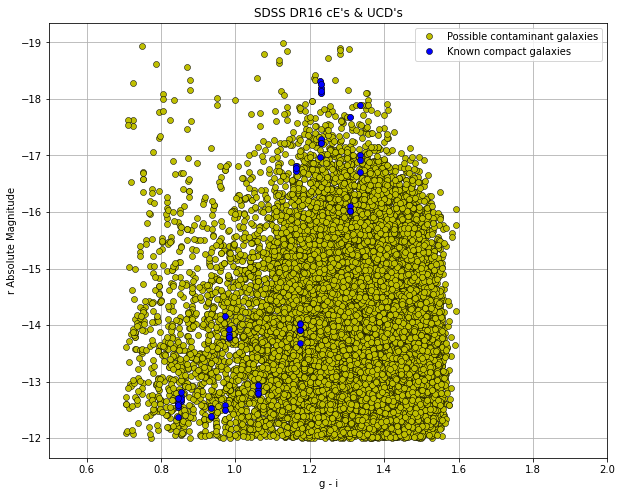

In [23]:
fig1 = plt.figure(figsize=(10,8))

plt.plot(g_i_mag_dr16,mv_r_dr16, 'yo', label = 'Possible contaminant galaxies', markeredgecolor= 'black', markeredgewidth =0.5 , markersize=6)

plt.xlabel('g - i')
plt.ylabel('r Absolute Magnitude')
plt.xlim(0.5,2)
# plt.ylim(-19,-12)
plt.title("SDSS DR16 cE's & UCD's")

plt.plot(g_i_mag_dr16[index_known_dr16],mv_r_dr16[index_known_dr16], 'bo', label = 'Known compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
# plt.plot(g_i_mag_dr7[index_unknown_dr7],mv_r_dr7[index_unknown_dr7], 'ro', label = 'Knsown compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(loc="upper right")
# plt.savefig('SDSS DR7 cE & UCD.pdf')

In [24]:
print('Total objects (including duplicates):',len(objid_dr16))
objid_filtered_dr16 = []
[objid_filtered_dr16.append(x) for x in objid_dr16 if x not in objid_filtered_dr16]
print('Unique objects:',len(objid_filtered_dr16))
objid_unique_dr16 = np.unique(objid_dr16)

Total objects (including duplicates): 21112
Unique objects: 16845


In [25]:
# finding index of each unique object
index_unique = []
index_b = []
for i in range(len(objid_filtered_dr16)):
    index_c = []
    index_e = []
    
    index_b = np.where(objid_filtered_dr16[i] == objid_dr16)[0]

    index_b = np.array(index_b)

    index_c.extend(index_b)

    index_e.append(index_c[0])

    
    if len(index_c) > 1:
        index_unique += index_e
    else:
        index_unique += index_c
        
index_unique = np.array(index_unique)

In [26]:
# make a link to sdss for each object
link_dr16 = []
for i in range(len(index_unique)):
    url = 'http://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=' + str(objid_dr16[index_unique][i])
    link_dr16.append(url)

In [28]:
# dictionary of lists  
dict = {'objid': objid_dr16[index_unique], 'ra': ra_dr16[index_unique], 'dec': dec_dr16[index_unique], 'g-i': g_mag_dr16[index_unique] - i_mag_dr16[index_unique], 'u-g': u_mag_dr16[index_unique] - g_mag_dr16[index_unique], 'u-z': u_mag_dr16[index_unique] - z_mag_dr16[index_unique], 'g-z': g_mag_dr16[index_unique] - z_mag_dr16[index_unique], 'g-r': g_mag_dr16[index_unique] - r_mag_dr16[index_unique],'z-w1':z_mag_dr16[index_unique] - w1_dr16[index_unique],'z-w2':z_mag_dr16[index_unique] - w2_dr16[index_unique],'z-w3':z_mag_dr16[index_unique] - w3_dr16[index_unique],'z-w4':z_mag_dr16[index_unique] - w4_dr16[index_unique], 'concentration_index': concentration_index_dr16[index_unique], 'photo_z': z_dr16[index_unique], 'frac_dev': fracdev_dr16[index_unique], 'host_galaxy': host_galaxy_list_dr16[index_unique], 'distance': distance_dr16[index_unique], 'axis_ratio': axis_ratio_dr16[index_unique], 'category': category_dr16[index_unique], 'radius': r_pc_dr16[index_unique], 'magnitude': mv_r_dr16[index_unique], 'u_mag': u_mag_dr16[index_unique], 'g_mag': g_mag_dr16[index_unique], 'i_mag': i_mag_dr16[index_unique], 'r_mag': r_mag_dr16[index_unique], 'z_mag': z_mag_dr16[index_unique],'w1': w1_dr16[index_unique], 'w2': w2_dr16[index_unique],'w3': w3_dr16[index_unique], 'w4': w4_dr16[index_unique], 'link': link_dr16} 
# saving the dataframe 
df = pd.DataFrame(dict) 
df.to_csv('atlas3d_search_dr16.csv') 

In [29]:
df_dr16 = pd.read_csv("atlas3d_search_dr16.csv")

In [31]:
print(df_dr16)

       Unnamed: 0                objid          ra       dec      g-i  \
0               0  1237650795683184774  146.280188 -0.406953  1.28936   
1               1  1237650795683250313  146.356000 -0.335718  0.90181   
2               2  1237648720679272634  146.629629 -0.465661  1.39465   
3               3  1237650795683315882  146.608015 -0.291308  0.84310   
4               4  1237648721216012486  146.378597 -0.112136  1.39317   
...           ...                  ...         ...       ...      ...   
16840       16840  1237678617417482442  359.174266  1.358364  1.46390   
16841       16841  1237657192515436772  359.158866  1.199073  1.47916   
16842       16842  1237678617417416790  359.056797  1.268158  1.39548   
16843       16843  1237657192515371194  359.027039  1.220538  1.43751   
16844       16844  1237678617417482447  359.183042  1.379003  1.38476   

           u-g      u-z      g-z      g-r     z-w1  ...     u_mag     g_mag  \
0      1.81941  3.43028  1.61087  0.88803  2

In [ ]:
# # %matplotlib qt
# fig1 = plt.figure(figsize=(10,8))
# # sns.set_context("paper", font_scale=3)
# sns.pairplot(df_dr7, 
#              vars = ['photo_z', 'frac_dev', 'concentration_index', 'g-i', 'u-g','u-z','g-z'],
#              corner=True,
#              diag_kind = 'kde', 
#              plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'},
#              height = 3);
# # plt.savefig('pairplot_dr7.pdf')
# # Title 
# plt.suptitle('SDSS DR7 pairplots', 
#              size = 30);